# 미세먼지 발생에 영향을 미치는 요인을 고려하고, 영향 인자 선정 및 발생량을 예측 ☁️😷

In [522]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as sml
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

import os

In [523]:
# matplotlib 패키지 한글 깨침 처리
matplotlib.rc('font', family = 'AppleGothic')
plt.rc('font', family = 'AppleGothic')

# 

# 1. 데이터 구성하기

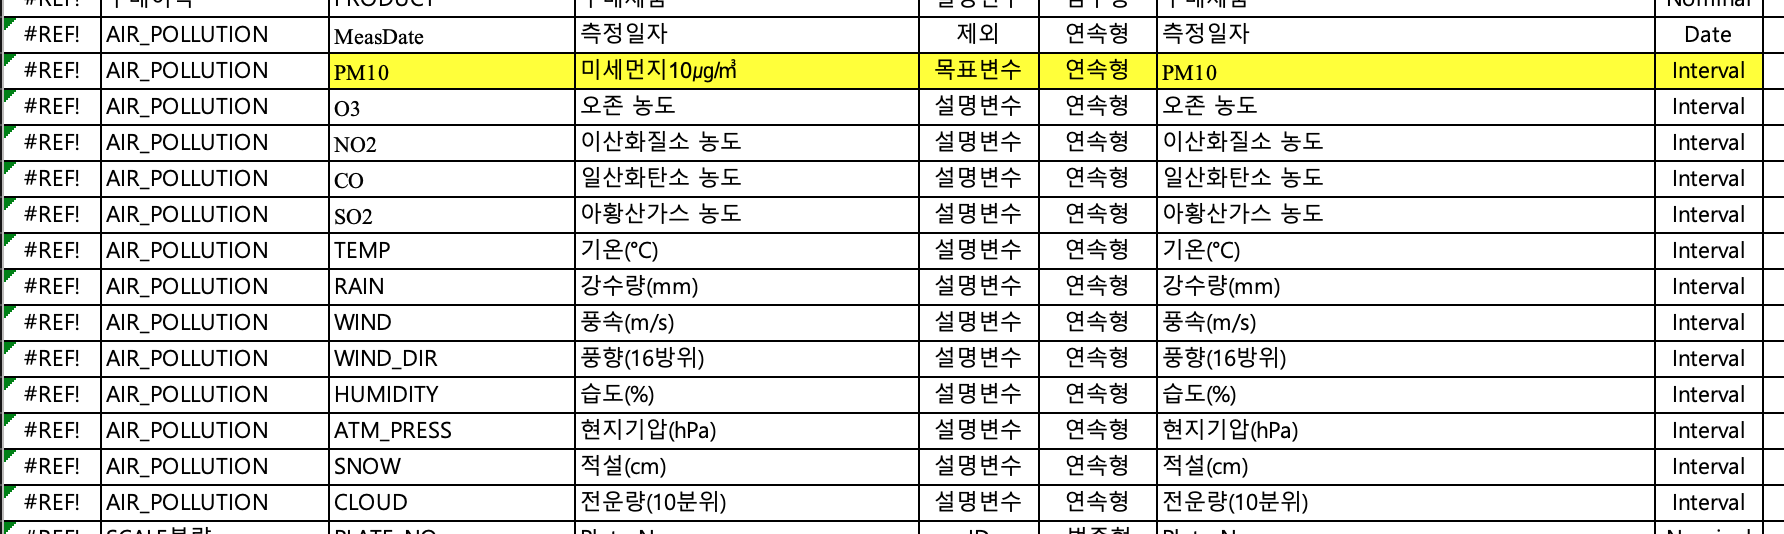

- 우선 데이터셋을 구성하고 있는 값을 살펴본다. 변수는 총 14개이고, **목표변수는 미세먼지발생량에 해당하는 'PM10'** 이다.
- 모든 변수들은 연속형이다.
- 측정일자와 목표변수(PM10)을 제외한 나머지 변수는 설명변수이다.
- 설명변수는 '대기오염', '기상정보', '고려대상' 3가지 집단으로 다시 구분지을 수 있다.


- **목표변수 : PM10(미세먼지발생량)**
- **설명변수1) 대기오염**
    - NO2(이산화질소 농도)
    - CO(이산화질소 농도)
    - SO2(아황산가스 농도)
- **설명변수2) 기상정보**
    - TEMP(기온)
    - ATM_PRESS(현지기압hPa)
    - HUMIDITY(습도%) : 습도가 높으면 장마철일 것이다.
    - RAIN(강수량mm) : 장마철(여름)에 강수량의 값이 높을 것이다.
    - WIND(풍속m/s) 
    - CLOUD(전운량10분위)
- **설명변수3) 고려대상**
    - O3(오존농도)
    - SNOW(적설cm) : 눈이 오는 겨울의 경우, 해당 값을 가질 것이다.
    - WIND_DIR(풍향16방위) : 풍향에 따라, 계절을 추측할 수 있을 것이다.

In [712]:
df_raw = pd.read_csv("./data2/AIR_POLLUTION.csv", engine="python")
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [654]:
# 데이터셋의 컬럼 종류와 속성 및 각 컬럼 개수 확인
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MeasDate   366 non-null    object 
 1   PM10       365 non-null    float64
 2   O3         365 non-null    float64
 3   NO2        365 non-null    float64
 4   CO         311 non-null    float64
 5   SO2        365 non-null    float64
 6   TEMP       366 non-null    float64
 7   RAIN       366 non-null    float64
 8   WIND       366 non-null    float64
 9   WIND_DIR   366 non-null    int64  
 10  HUMIDITY   366 non-null    float64
 11  ATM_PRESS  366 non-null    float64
 12  SNOW       366 non-null    float64
 13  CLOUD      366 non-null    float64
dtypes: float64(12), int64(1), object(1)
memory usage: 40.2+ KB


- 미세먼지 데이터는 **변수 14개, 자료수 366개**로 구성되어 있다.

In [655]:
df_raw.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,311.000000,365.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.421918,0.023600,0.026814,0.517042,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.937983,0.011896,0.010271,0.152820,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


In [656]:
# 데이터셋 내 결측치 존재 여부 확인 및 각 변수당 결측치 개수 총합 확인
df_raw.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

- **CO(일산화질소) 변수에 55개의 결측치 존재 => 어떻게 처리할 것인가?!**
- PM10(미세먼지발생량) 변수에 1개의 결측치 존재 (목표변수)
- O3(오존농도), NO2(이산화질소농도), SO2(아황산질소농도) 변수에 각 1개씩의 결측치 존재 (설명변수)

In [657]:
df_raw['CO'].unique()

array([0.5, 0.4, 0.3, 0.6, 0.7, nan, 0.8, 0.9, 1. ])

- 55개의 결측치를 가진 'CO'는 위와 같은 유니크한 값을 갖는다. 결측치는 nan으로 표기함을 확인할 수 있었다.

# 2. EDA

### 1) PM10(미세먼지발생량)이 높은 순서대로 보기

In [658]:
df_raw.sort_values(by="PM10", ascending=False).head(10)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
162,2019-12-10,101.0,0.010,0.055,1.0,0.004,8.12,0.85,1.22,148,80.6,1008.7,0.0,8.83
315,2020-05-11,92.0,0.034,0.018,0.5,0.002,16.65,0.03,2.96,276,60.8,998.0,0.0,7.50
123,2019-11-01,89.0,0.027,0.037,0.6,0.003,15.30,0.00,1.80,256,60.0,1011.1,0.0,2.42
120,2019-10-29,83.0,0.021,0.023,0.4,0.003,13.05,0.25,2.40,286,62.1,1004.9,0.0,2.21
228,2020-02-14,81.0,0.011,0.043,0.9,0.003,7.99,0.00,1.20,210,70.8,1010.2,0.0,3.42
227,2020-02-13,75.0,0.015,0.032,0.7,0.003,6.71,0.00,1.68,236,85.4,1008.2,0.0,8.79
163,2019-12-11,73.0,0.021,0.032,0.7,0.004,6.95,0.10,3.26,230,64.5,1006.6,0.0,5.58
122,2019-10-31,72.0,0.022,0.041,0.6,0.004,14.23,0.00,2.21,138,72.8,1010.3,0.0,4.38
176,2019-12-24,72.0,0.006,0.045,1.0,0.003,0.87,0.00,1.26,105,68.4,1016.5,0.0,0.42
207,2020-01-24,71.0,0.018,0.029,0.8,0.004,2.98,0.00,1.81,241,62.7,1019.2,0.0,3.88


★ **황사와 미세먼지발생량의 관계에 대해 생각해보기**
- 황사는 중국, 몽골 등 발원지 지역에서 바람에 의하여 하늘 높이 불려 올라간 미세먼지가 대기 중에 퍼져서 하늘을 덮었다가 서서히 떨어지는 현상
- 황사가 발생하기 쉬운 조건? 지면 온도가 높아지고, 강수량이 적어지는 것


- 아시아 대륙은 주로 3월과 5월 사이(봄)에 심한 황사가 발생하곤 했지만, 2000년도 이후로 점차 겨울에도 심한 황사가 자주 발생하고 있다고 한다.
- 이는 황사 발원지 지역에서 최근 10년간 발생한 강수량이 평년에 비해 25% 밖에 되지 않고, 기온은 점점 상승하지만 강수량이 점점 줄어들게 되는 건조화, 사막화가 진행되고 있기 때문이다.


- PM10(미세먼지발생량)이 높은 순서대로 상위 10개의 데이터를 보면, 2번째(2005-05-11)을 제외한 데이터는 가을~겨울의 계절에 해당하는 것을 확인할 수 있다.

### 2) PM10(미세먼지발생량)이 낮은 순서대로 보기

In [659]:
df_raw.sort_values(by="PM10", ascending=True).head(10)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
10,2019-07-11,5.0,0.023,0.014,0.3,0.002,21.79,0.23,1.30,204,79.0,995.2,0.0,9.63
365,2020-06-30,6.0,0.039,0.009,0.3,0.002,20.60,5.60,4.00,50,92.0,983.8,0.0,10.00
324,2020-05-20,6.0,0.020,0.015,0.3,0.002,14.13,0.00,1.86,88,59.8,1001.2,0.0,7.00
72,2019-09-11,7.0,0.032,0.020,NaN,0.002,24.38,1.03,3.07,330,73.6,1004.2,0.0,8.29
45,2019-08-15,8.0,0.010,0.015,NaN,0.002,26.31,1.62,1.33,99,79.2,984.2,0.0,9.08
65,2019-09-04,8.0,0.015,0.027,NaN,0.002,22.79,1.51,2.51,351,88.0,1003.2,0.0,9.17
94,2019-10-03,8.0,0.017,0.017,0.3,0.003,22.38,0.64,2.82,287,74.5,995.7,0.0,6.67
83,2019-09-22,8.0,0.034,0.014,0.3,0.002,18.64,0.05,3.55,340,63.0,1003.9,0.0,9.67
9,2019-07-10,9.0,0.027,0.019,0.3,0.002,22.79,0.82,2.13,80,61.0,997.3,0.0,8.29
190,2020-01-07,9.0,0.008,0.031,0.5,0.003,6.06,4.98,4.18,73,95.0,1001.2,0.0,10.00


- PM10(미세먼지발생량)이 낮은 순서대로 상위 10개의 데이터를 보면, 대체로 여름철~초가을에 해당하는 값이 많다. 

In [660]:
df_date = df_raw
# measdate 앞 여섯 자리 추출
df_date['MeasDate'] = df_date['MeasDate'].str[0:7]
df_date.rename(columns = {'MeasDate': 'DATE'}, inplace=True)
df_date.head(3)

,DATE,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29


### 3) 년월에 따른 미세먼지발생 추이를 그래프로 확인

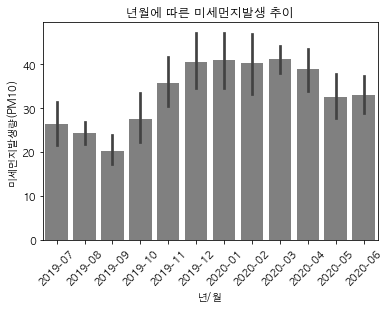

In [661]:
df_pm10_date_plot = sns.barplot(x='DATE', y='PM10', data=df_date, color='grey')
df_pm10_date_plot.set_title("년월에 따른 미세먼지발생 추이")
df_pm10_date_plot.set_xlabel("년/월")
df_pm10_date_plot.set_ylabel("미세먼지발생량(PM10)")
plt.xticks(rotation=45)
plt.show()

- 2019년 9월의 미세먼지발생량(PM10)이 가장 낮은 것을 확인할 수 있다.
- 한편, 2020년 1월의 미세먼지발생량(PM10)이 가장 높은 것을 확인할 수 있다.


- 여름철에는 비교적 미세먼지발생량(PM10)이 낮은 편이다.
- 가을~겨울~초봄에 걸쳐 미세먼지발생량(PM10)은 증가세를 보이며, 20년 5월부터 다시 감소세를 보인다.

### 4) 강수량(RAIN)/적설(SNOW)에 따라 미세먼지발생량(PM10)이 달라지지 않을까?

- 비가 많이 오거나, 눈이 많이 오는 날엔 미세먼지발생량이 적지 않을까? 라고 생각했다.
- 강수량(RAIN)과 적설(SNOW) 컬럼에 대하여 살펴보겠다!

In [662]:
df_raw['RAIN'].value_counts()

0.00    252
0.10      7
0.30      6
0.03      6
0.05      4
       ... 
0.70      1
0.35      1
1.90      1
5.60      1
0.16      1
Name: RAIN, Length: 80, dtype: int64

- 강수량과 미세먼지발생량의 관계를 보기 위해, RAIN 컬럼의 값을 살펴보았다.
- 결측치는 없지만, **0.00 으로 대부분의 값이 채워져있다.**
- **일반적으로 강수량이 높은 장마철(7-8월)에도 0.00으로 채워진 일자가 많았다.**
- **RAIN 데이터를 사용해야할 지 고민이 된다.**

In [663]:
df_raw['SNOW'].value_counts()

0.0    360
0.6      1
3.2      1
1.7      1
2.1      1
0.3      1
0.5      1
Name: SNOW, dtype: int64

- 적설 또한 결측치는 없지만 **대부분의 값이 0.0으로** 채워져있음을 확인할 수 있다.
- **본 과제의 데이터가 어떤 장소를 기준으로 집계된 것인지도 확인되지 않는다.**
- 전국을 기준으로 하는 것인지, 특정 지역으로 기준으로 하는 것인지 알 수 없다.(한국 기준인지도 모르겠음)


- 데이터가 한국에서 집계되었다고 가정한다. **겨울철에 눈이 거의 오지 않는 경상권 지역의 데이터라면 의미가 있겠지만, 겨울철에 눈이 많이 오는 수도권 또는 강원 지역의 데이터라면 의미가 없을 것**이다.
- **SNOW 데이터를 사용해야할 지 고민이 된다.**

### 5) 습도(HUMIDITY)에 따라 미세먼지발생량(PM10)이 달라지지 않을까?

- 4)에서 강수량(RAIN)과 적설(SNOW)를 이용하기는 어렵다고 판단했다.
- 습도(HUMIDITY)가 높으면 미세먼지발생량(PM10)이 줄어들지 않을까? 라고 생각했다.

In [664]:
df_raw['HUMIDITY'].value_counts()

52.5    4
62.5    3
59.8    3
61.5    3
64.5    3
       ..
72.8    1
73.9    1
78.2    1
53.4    1
45.5    1
Name: HUMIDITY, Length: 258, dtype: int64

In [665]:
df_raw['HUMIDITY'].unique()

array([63.2, 65.3, 58.6, 45.5, 39.7, 43.5, 45.3, 46.3, 61. , 79. , 66.7,
       67.4, 65.2, 77.9, 80.8, 74.5, 64.9, 61.2, 63.1, 87.1, 74.7, 71.5,
       82.3, 90.5, 94.9, 78.6, 75. , 75.3, 91.3, 85.8, 74.8, 70.6, 73.4,
       67.3, 52. , 76.1, 72. , 68.5, 59.4, 51.3, 91. , 76.3, 66.2, 79.2,
       76.8, 70. , 65.1, 62. , 56.6, 64.7, 67.5, 60.4, 63.9, 70.8, 66.6,
       77.6, 64.5, 64.4, 57. , 88. , 91.7, 80.4, 73.8, 77.1, 73.6, 69. ,
       62.4, 77.8, 55. , 40. , 45.7, 45.6, 51.6, 59.7, 63. , 50.1, 60.6,
       64.2, 59.6, 57.5, 58.8, 62.5, 66. , 87. , 70.3, 73.3, 54. , 89.8,
       48. , 60.3, 48.8, 52.5, 58.5, 53.4, 55.5, 58.3, 62.6, 71. , 61.3,
       57.4, 58.4, 48.3, 55.6, 62.1, 60.2, 72.8, 60. , 57.2, 57.6, 66.4,
       46.5, 30.1, 58.7, 73.5, 64.6, 30.4, 82.5, 82. , 78.3, 62.8, 48.5,
       36.4, 38.2, 33.1, 50.4, 61.6, 52.1, 44.7, 41.4, 76.7, 50.5, 58.1,
       33.5, 33.3, 80.6, 45. , 50.9, 52.2, 59. , 65.9, 49. , 44.1, 64.1,
       63.5, 79.3, 68.4, 46.9, 47.6, 49.6, 41.7, 61

- 강수량(RAIN)과 적설(SNOW) 컬럼과는 달리 다양한 값으로 고루 채워져있다는 것을 확인했다.

Text(0, 0.5, '미세먼지발생량(PM10)')

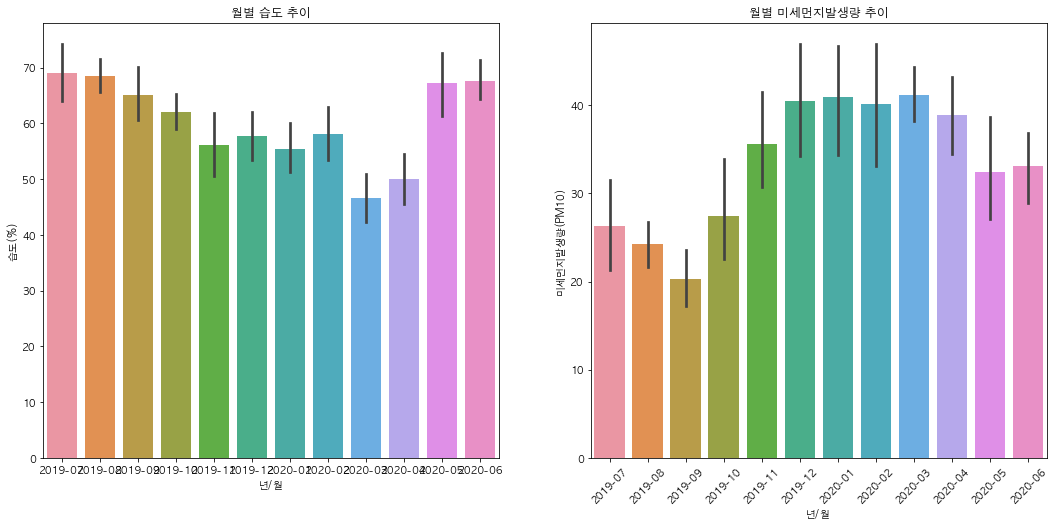

In [666]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")
date_humidity = sns.barplot(x='DATE',y='HUMIDITY', data=df_date, ax=ax[0])
ax[0].set_title("월별 습도 추이")
ax[0].set_xlabel("년/월")
ax[0].set_ylabel("습도(%)")


date_pm10 = sns.barplot(x='DATE',y='PM10', data=df_date, ax=ax[1])
ax[1].set_title("월별 미세먼지발생량 추이")
ax[1].set_xlabel("년/월")
ax[1].set_ylabel("미세먼지발생량(PM10)")

- 월별 습도(HUMIDITY) 추이와 월별 미세먼지발생량(PM10) 추이 그래프를 그려보았다.
- 일반화하기는 어렵지만, 습도가 줄어드는 '2019-10'부터 '2020-04'부터 미세먼지발생량은 증가하는 추세를 보이는 것을 확인할 수 있다.


- 위 그래프로 미루어보아, <br>**습도가 낮아지면 미세먼지발생량은 증가한다(=습도가 높아지면 미세먼지발생량은 감소한다)**는 것을 추측해볼 수 있다.

### 6) 온도(TEMP)와 습도(HUMIDITY)의 관계

- 5)에서 월별 습도 추이를 확인하고나니, 온도(TEMP)와 습도(HUMIDITY)의 관계가 궁금해졌다.

In [667]:
df_raw['TEMP'].value_counts()

 6.32     2
 4.50     2
-0.64     2
-0.03     2
 13.35    2
         ..
 31.40    1
 9.79     1
 26.15    1
 20.33    1
 26.00    1
Name: TEMP, Length: 344, dtype: int64

In [668]:
print("'TEMP' 컬럼에서 추출한 최고기온 : {}".format(df_raw['TEMP'].max()))
print("'TEMP' 컬럼에서 추출한 최저기온 : {}".format(df_raw['TEMP'].min()))

'TEMP' 컬럼에서 추출한 최고기온 : 31.72
'TEMP' 컬럼에서 추출한 최저기온 : -7.95


Text(0, 0.5, '습도(%)')

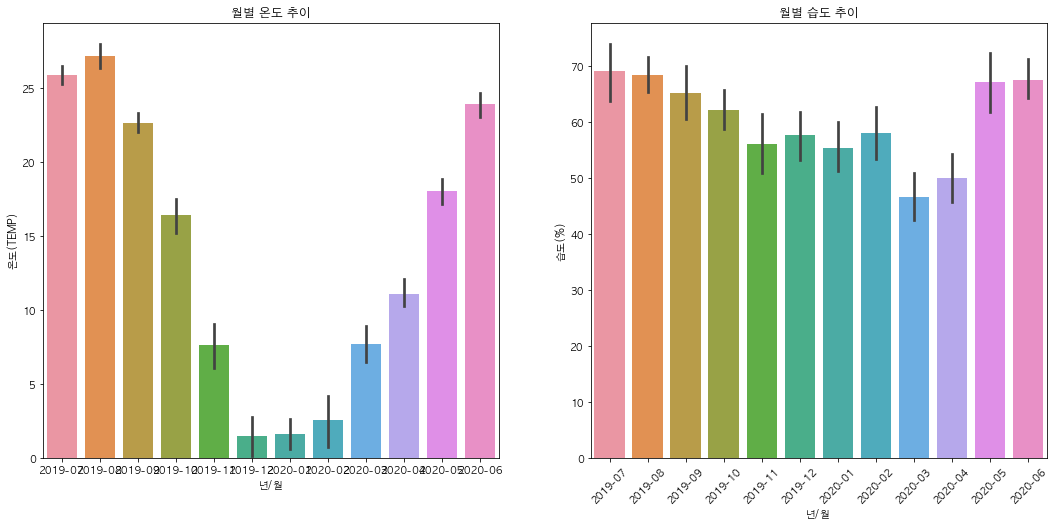

In [669]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")


date_temp = sns.barplot(x='DATE',y='TEMP', data=df_date, ax=ax[0])
ax[0].set_title("월별 온도 추이")
ax[0].set_xlabel("년/월")
ax[0].set_ylabel("온도(TEMP)")

date_humidity = sns.barplot(x='DATE',y='HUMIDITY', data=df_date, ax=ax[1])
ax[1].set_title("월별 습도 추이")
ax[1].set_xlabel("년/월")
ax[1].set_ylabel("습도(%)")

- 온도(TEMP)와 습도(HUMIDITY) 간의 절대적인 비례관계가 있다고 보기는 어렵지만, **온도가 감소하는 구간에서는 습도 또한 다소 감소하는 추세를 보임**을 확인할 수 있다.

### 7) 기압(ATM_PRESS)과 온도(TEMP)의 관계

In [670]:
df_raw['ATM_PRESS'].value_counts()

996.6     6
1006.7    6
1013.5    5
997.9     4
1018.8    4
         ..
1014.9    1
1025.5    1
1017.9    1
991.1     1
993.5     1
Name: ATM_PRESS, Length: 216, dtype: int64

In [671]:
print("'ATM_PRESS' 컬럼에서 추출한 최고기압 : {}".format(df_raw['ATM_PRESS'].max()))
print("'ATM_PRESS' 컬럼에서 추출한 최저기압 : {}".format(df_raw['ATM_PRESS'].min()))

'ATM_PRESS' 컬럼에서 추출한 최고기압 : 1025.5
'ATM_PRESS' 컬럼에서 추출한 최저기압 : 983.8


Text(0, 0.5, '기압(hPa)')

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


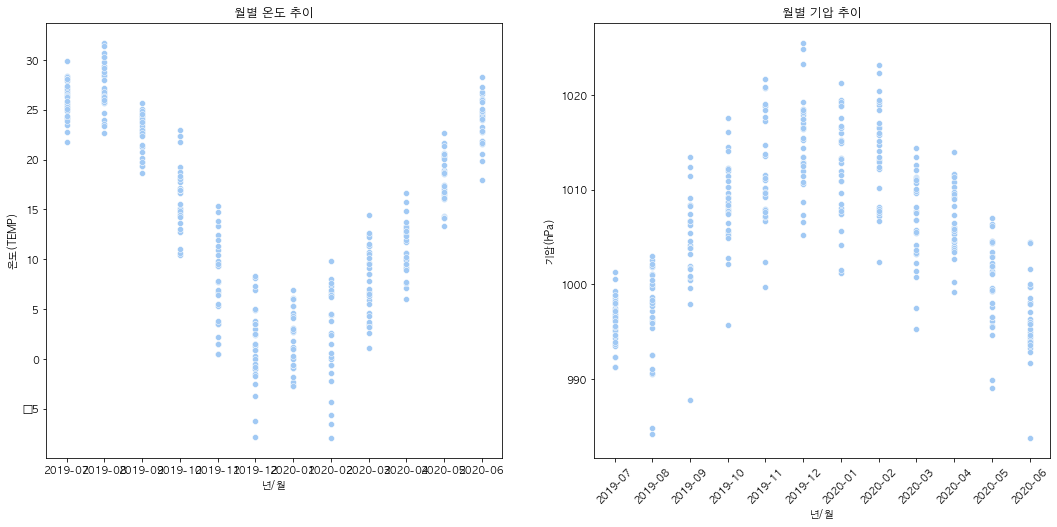

In [672]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")

date_temp = sns.scatterplot(x='DATE',y='TEMP', data=df_date, ax=ax[0])
ax[0].set_title("월별 온도 추이")
ax[0].set_xlabel("년/월")
ax[0].set_ylabel("온도(TEMP)")

date_humidity = sns.scatterplot(x='DATE',y='ATM_PRESS', data=df_date, ax=ax[1])
ax[1].set_title("월별 기압 추이")
ax[1].set_xlabel("년/월")
ax[1].set_ylabel("기압(hPa)")

- 위 그래프로 미루어보아, **온도(TEMP)와 기압(ATM_PRESS)은 반비례하는 특성**임을 알 수 있다.
    - 온도가 오르면? 기압은 낮아지고
    - 온도가 낮아지면? 기압은 오른다

### 8) 풍속(WIND)와 풍향(WIND_DIR)의 관계

**[ 풍속(WIND) ]**

In [673]:
df_raw['WIND'].value_counts()

1.98    10
1.85     7
2.10     7
1.96     7
1.70     6
        ..
3.29     1
5.88     1
1.97     1
3.12     1
1.28     1
Name: WIND, Length: 186, dtype: int64

In [674]:
print("'WIND' 컬럼에서 추출한 최고풍속 : {}m/s".format(df_raw['WIND'].max()))
print("'WIND' 컬럼에서 추출한 최저풍속 : {}m/s".format(df_raw['WIND'].min()))

'WIND' 컬럼에서 추출한 최고풍속 : 5.88m/s
'WIND' 컬럼에서 추출한 최저풍속 : 0.94m/s


**[ 풍향(WIND_DIR) ]**

In [675]:
df_raw['WIND_DIR'].unique()

array([249, 265, 280, 263, 175,  80,  83,  76,  81, 204, 210, 264, 133,
       152, 189, 192, 107,  88, 178, 230, 200, 148, 187, 151, 179, 197,
       203, 195, 237, 185, 165, 164,  67, 225,  95,  97,  90, 205, 109,
        99, 228, 253, 245, 124, 115, 177, 174, 278, 207, 149, 218, 127,
       215, 240, 255, 268, 351, 288, 344, 193, 262, 271, 330, 243, 239,
       299, 333, 231, 222, 303, 254, 340, 274, 269, 259, 302, 257, 234,
       281, 226, 329, 287, 238, 235, 217, 247, 220, 258, 285, 327, 261,
       221, 290, 223, 275, 130,  66,  70, 183, 295, 241, 136, 286, 196,
       138, 256, 160, 135, 156, 305, 273, 159, 150, 252,  50,  78, 307,
       232, 110, 166, 163, 310, 250, 168, 153, 182, 283, 296, 128,  71,
       113, 236,  63, 198, 289, 279, 314,  91, 267, 105,  79,  69, 145,
       298,  74,  73, 233, 308, 266, 277, 191,  57, 172, 106,  92,  98,
       158, 216, 323, 301, 224, 125, 142, 270, 284, 248, 134, 213, 176,
       276, 143, 293, 170, 190, 206, 161, 169, 212, 180, 260, 30

- 16방위라고 해서, 16개의 값만 있을 거라고 생각했는데 전처리가 필요해보인다.

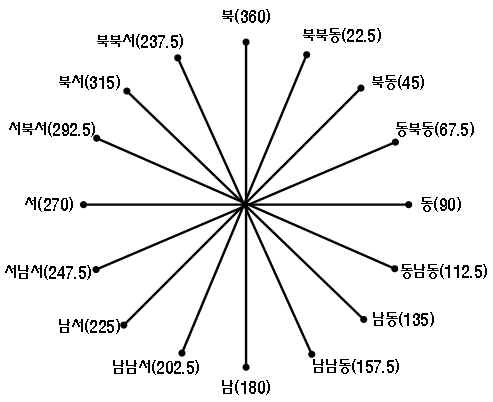

In [676]:
df_date2 = df_date # 복사본을 만들자!

def Change_WindDir(x):
        if x > 0 and x <= 22.5: return '북북동'  
        elif x > 22.5 and x <= 45: return '북동'  
        elif x > 45 and x <= 67.5: return '동북동' 
        elif x > 67.5 and x <= 90: return '동'  
        
        elif x > 90 and x <= 112.5: return '동남동'  
        elif x > 112.5 and x <= 135: return '남동'  
        elif x > 135 and x <= 157.5: return '남남동'  
        elif x > 157.5 and x <= 180: return '남'  
        
        elif x > 180 and x <= 202.5: return '남남서'  
        elif x > 202.5 and x <= 225: return '남서'  
        elif x > 225 and x <= 247.5: return '서남서'  
        elif x > 247.5 and x <= 270: return '서'  
        
        elif x > 270 and x <= 292.5: return '서북서'  
        elif x > 292.5 and x <= 315: return '북서'  
        elif x > 315 and x <= 237.5: return '북북서'  
        else: return '북'

# WIND_DIR의 값에 대응하는 16방위를 적용한다. 값 변경!
df_date2["WIND_DIR"] = df_date2["WIND_DIR"].apply(Change_WindDir)

In [677]:
df_date2['WIND_DIR'].value_counts()

서      56
서북서    47
남서     39
서남서    38
남남서    34
남      31
북서     26
남남동    24
동      21
동남동    20
남동     12
동북동    10
북       8
Name: WIND_DIR, dtype: int64

- 서풍, 서풍서풍, 남서풍, 서남서풍, 남남서풍 순으로 방위에서 높은 비율을 차지하고 있다.

Text(0.5, 0, ' ')

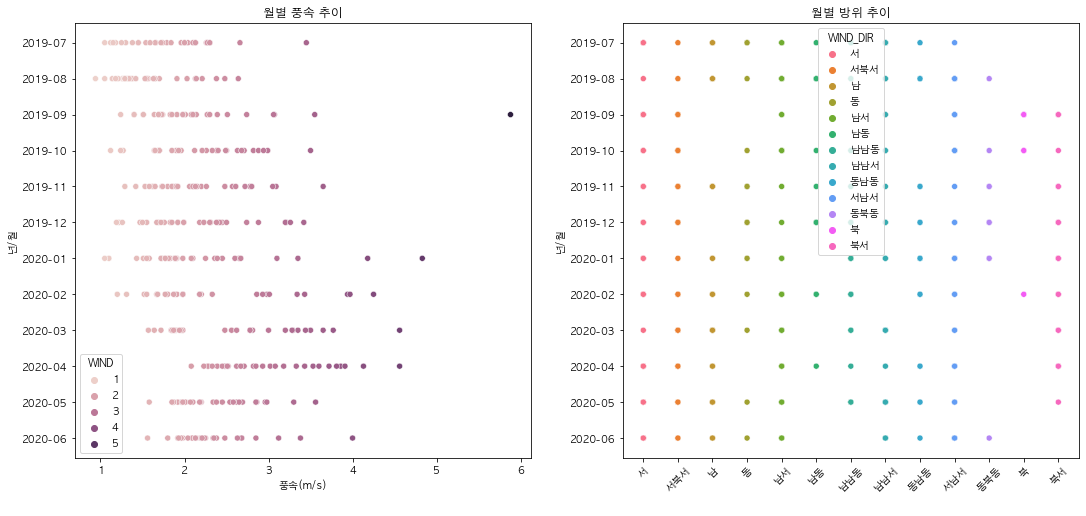

In [678]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")

date_temp = sns.scatterplot(x='WIND', y='DATE', hue='WIND', data=df_date, ax=ax[0])
ax[0].set_title("월별 풍속 추이")
ax[0].set_ylabel("년/월")
ax[0].set_xlabel("풍속(m/s)")

date_winddir = sns.scatterplot(x='WIND_DIR',y='DATE', hue='WIND_DIR', data=df_date2, ax=ax[1])
ax[1].set_title("월별 방위 추이")
ax[1].set_ylabel("년/월")
ax[1].set_xlabel(" ")

- 풍속(WIND)을 살표보면, 여름철보다 겨울철의 풍속이 빠른 편임을 알 수 있다.
- 방위(WIND-DIR) 추이를 살펴보면, 계절에 크게 편향되는 방위를 특정하기는 어렵다.
- 동북동풍, 북풍의 경우 1년에 걸쳐 부는 바람은 아닌 듯하다..

### 9) 기압(ATM_PRESS)와 전운량(CLOUD)의 관계

In [695]:
df_raw = pd.read_csv("./data2/AIR_POLLUTION.csv", engine="python")
df_date = df_raw
# measdate 앞 여섯 자리 추출
df_date['MeasDate'] = df_date['MeasDate'].str[0:7]
df_date.rename(columns = {'MeasDate': 'DATE'}, inplace=True)

In [696]:
df_raw['CLOUD'].value_counts()

0.00    15
7.04     6
0.04     5
2.13     5
9.88     5
        ..
9.92     1
9.54     1
5.13     1
0.58     1
0.42     1
Name: CLOUD, Length: 188, dtype: int64

Text(0, 0.5, '기압(hPa)')

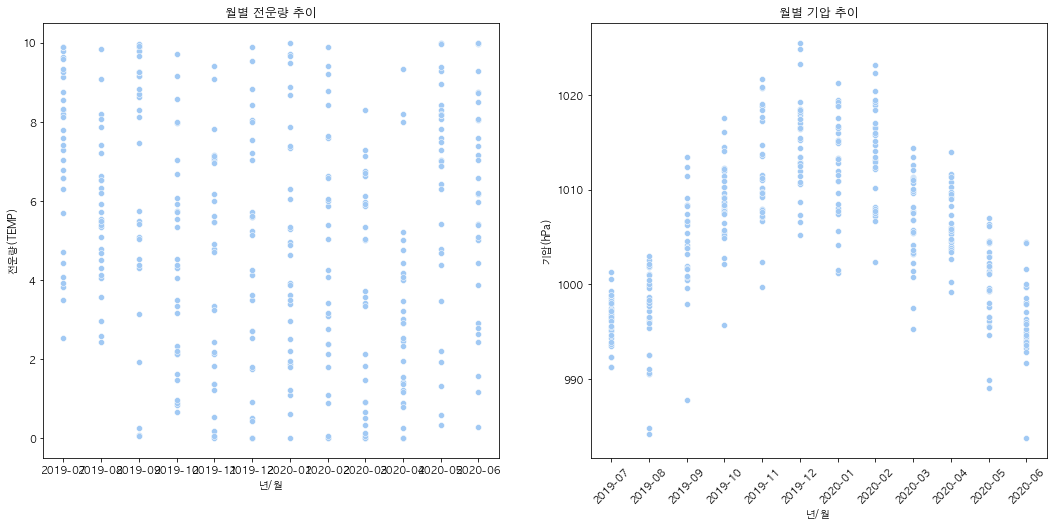

In [697]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")

date_cloud = sns.scatterplot(x='DATE',y='CLOUD', data=df_raw, ax=ax[0])
ax[0].set_title("월별 전운량 추이")
ax[0].set_xlabel("년/월")
ax[0].set_ylabel("전운량(TEMP)")

date_atmpress = sns.scatterplot(x='DATE',y='ATM_PRESS', data=df_date, ax=ax[1])
ax[1].set_title("월별 기압 추이")
ax[1].set_xlabel("년/월")
ax[1].set_ylabel("기압(hPa)")

In [680]:
print("'CLOUD' 컬럼에서 추출한 최다 전운량 : {}".format(df_raw['CLOUD'].max()))
print("'CLOUD' 컬럼에서 추출한 최소 전운량 : {}".format(df_raw['CLOUD'].min()))

'CLOUD' 컬럼에서 추출한 최다 전운량 : 10.0
'CLOUD' 컬럼에서 추출한 최소 전운량 : 0.0


- **기상청**(https://www.weather.go.kr/weather/climate/past_cal.jsp)**에 따르면**
    - **운량 -> 맑음(0-5), 구름많음(6-8), 흐림(9-10)**
    - 운량은 0.0 ~ 10.0으로 표현되며 강수현상이나 강수유무와 관계없이 하루 평균 구름의 양입니다.
    
    
 - 기상청의 기준에 따라 운량 전처리를 하고 데이터를 살펴보기로!

In [701]:
df_date2 = df_date
def Change_cloud(x):
        if x <= 5: return '맑음' 
        elif x > 5 and x <= 8: return '구름많음'  
        else: return '흐림'

# CLOUD의 값에 대응하는 운량을 적용한다. 값 변경!
df_date2["CLOUD"] = df_date2["CLOUD"].apply(Change_cloud)

In [702]:
df_date2["CLOUD"].value_counts()

맑음      173
구름많음    115
흐림       78
Name: CLOUD, dtype: int64

- 약 1년에 달하는 데이터셋의 전운량은 맑음, 구름많음, 흐림 순으로 구성되어있다.

Text(0, 0.5, '기압(hPa)')

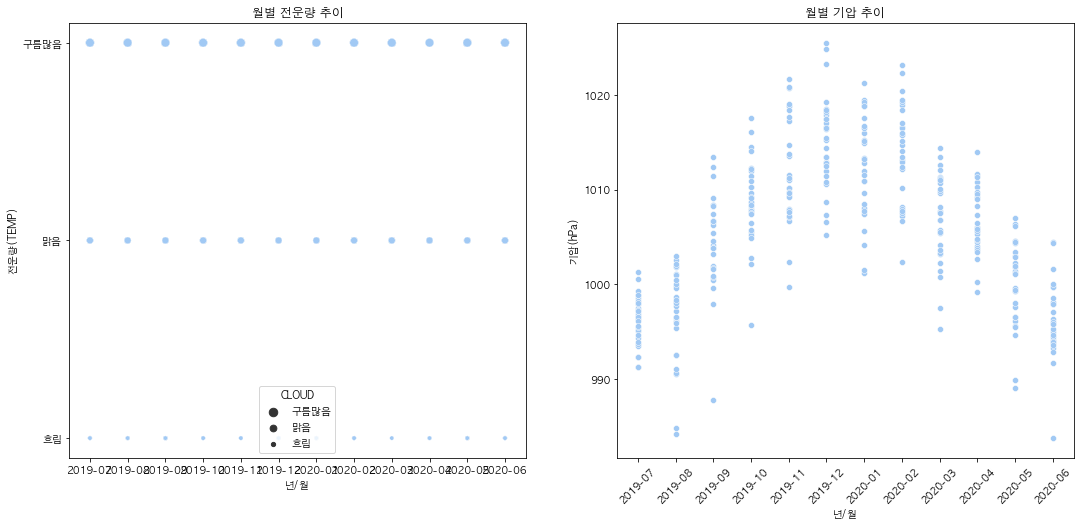

In [703]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")

date_cloud = sns.scatterplot(x='DATE',y='CLOUD', size='CLOUD', data=df_date2, ax=ax[0])
ax[0].set_title("월별 전운량 추이")
ax[0].set_xlabel("년/월")
ax[0].set_ylabel("전운량(TEMP)")

date_atmpress = sns.scatterplot(x='DATE',y='ATM_PRESS', data=df_date, ax=ax[1])
ax[1].set_title("월별 기압 추이")
ax[1].set_xlabel("년/월")
ax[1].set_ylabel("기압(hPa)")

- **전운량은 특정 월에 치우쳐 있는 형태가 아니고, 구름많음/맑음/흐림이 고루 분포되어 있음**을 알 수 있다.

### 10) 기온(TEMP)과 오존(O3)의 관계

미국 위스콘신 대학교 연구팀이 미 동부지역에서 **여름철에 급증하는** 에어컨 가동으로 **대기오염**이 얼마나 더 심해지고 그로 인해 조기사망자가 얼마나 더 발생하는지 산출한 연구결과를 발표했다(Abel et al.,2018).

연구결과에 따르면 21세기 중반까지 미국 동부지역에서는 **여름철(7월) 초미세먼지(PM2.5) 농도가 현재보다 58.6%(2.5㎍/㎥)까지 높아지고 오존 농도 또한 14.9%(8.06ppb)나 높아질 것으로 예상**됐다. 지구온난화로 기후가 변하면서 나타나는 결과다. 특히 지구온난화로 에어컨 가동에 필요한 추가적인 전기 생산 과정에서 나타나는 영향까지 고려할 경우 21세기 중반까지 여름철 초미세먼지 농도는 현재보다 61.1%(2.6㎍/㎥)나 높아지고 오존 농도 또한 15.9%(8.64ppb)나 높아질 것으로 예측됐다. 에어컨 가동에 필요한 추가적인 전기 생산 과정에서 초미세먼지 농도가 3.8% 높아지고 오존 농도도 6.7%나 높아지는 것이다.

(SBS 뉴스 / https://news.sbs.co.kr/news/endPage.do?news_id=N1004845983&plink=COPYPASTE&cooper=SBSNEWSEND )

- 기온이 높아지는 여름철의 경우, 에어컨 가동량이 급증하는데 이로 인한 오존 농도가 상승할 것이라고 생각했다.

Text(0, 0.5, '기온')

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


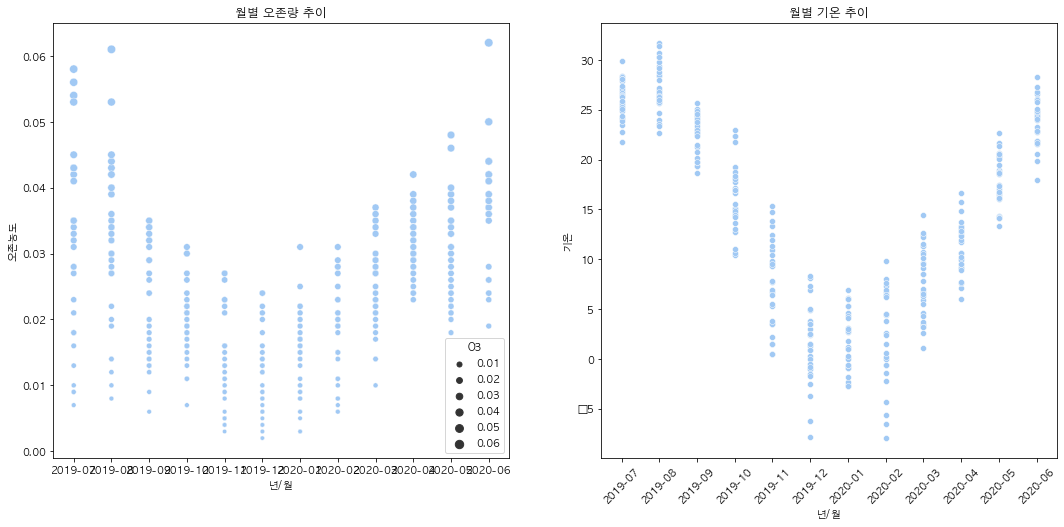

In [706]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.xticks(rotation=45)

sns.set_palette("pastel")

date_cloud = sns.scatterplot(x='DATE',y='O3', size='O3', data=df_date2, ax=ax[0])
ax[0].set_title("월별 오존량 추이")
ax[0].set_xlabel("년/월")
ax[0].set_ylabel("오존농도")

date_atmpress = sns.scatterplot(x='DATE',y='TEMP', data=df_date, ax=ax[1])
ax[1].set_title("월별 기온 추이")
ax[1].set_xlabel("년/월")
ax[1].set_ylabel("기온")

- 겨울철과 비교했을 때, 여름철의 오존량 추이가 높음을 확인할 수 있다.

### 11) 대기오염에 해당하는 설명변수들

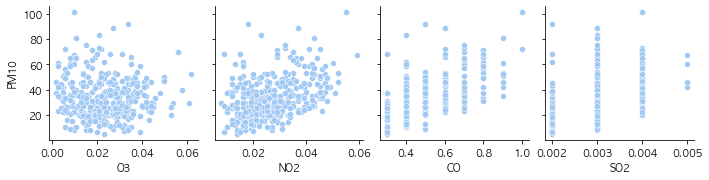

In [564]:
sns.set_palette("pastel")
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "NO2", "CO", "SO2"], diag_kind = None)

### 12) 기상정보에 해당하는 설명변수들

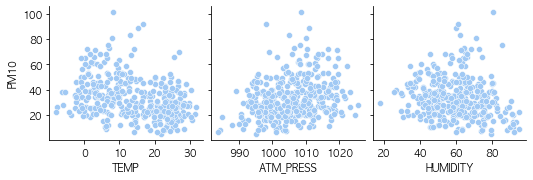

In [565]:
sns.pairplot(df_raw, y_vars="PM10", x_vars=["TEMP", "ATM_PRESS", "HUMIDITY"], diag_kind = None)

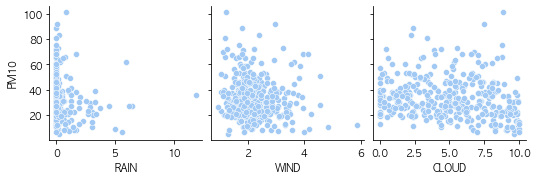

In [566]:
sns.pairplot(df_raw, y_vars="PM10", x_vars=["RAIN", "WIND", "CLOUD"], diag_kind = None)

### 13) 고려대상에 해당하는 설명변수들

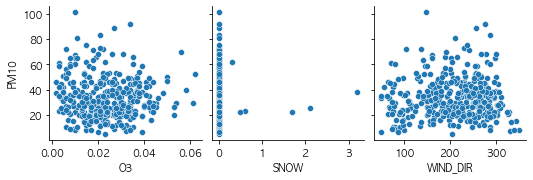

In [375]:
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "SNOW", "WIND_DIR"], diag_kind = None)

# 3. 변수들의 결측 및 이상치 처리

In [713]:
df_raw = pd.read_csv("./data2/AIR_POLLUTION.csv", engine="python")
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [714]:
# 데이터셋 내 결측치 존재 여부 확인 및 각 변수당 결측치 개수 총합 확인
df_raw.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

<AxesSubplot:>

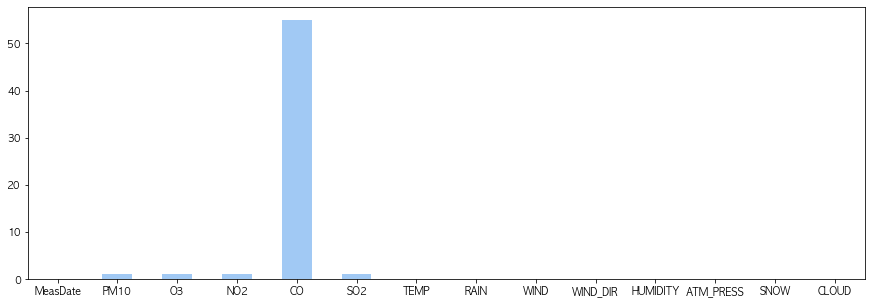

In [715]:
df_missing = df_raw.isna().sum()
df_missing.plot.bar(figsize=(15,5), rot=0)

- 결측치 건수를 bar차트로 확인하면 위 그래프와 같다. 
- 우선, 결측치가 1건인 변수들에 대해 결측치 처리를 하겠다!

### 1) 목표변수 결측치 처리 : PM10

- csv파일에서 PM10의 결측치가 발생한 행을 살펴보면, '2020.5.24' 일자의 데이터임을 확인할 수 있다.
- 2019년 5월의 PM10 평균과 2020년 5월 PM10의 평균을 비교하여 적절한 값을 대체하고자 했으나 2019년 5월의 데이터가 없으므로 '2020.5.24'일자를 제외한 5월의 평균 값으로 대체하고자 한다.

In [716]:
# 20년 5월의 값만 담은 데이터프레임 생성
mask = (df_raw['MeasDate'] > '2020-04-30') & (df_raw['MeasDate'] <= '2020-05-31')
may_df = pd.DataFrame(df_raw.loc[mask])
may_df.tail(10)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
326,2020-05-22,46.0,0.026,0.031,0.5,0.004,18.58,0.00,1.97,181,67.3,1002.9,0.0,8.17
327,2020-05-23,50.0,0.022,0.023,0.5,0.003,20.06,0.00,2.19,268,65.9,1001.1,0.0,6.88
328,2020-05-24,NaN,NaN,NaN,NaN,NaN,17.48,1.45,2.85,257,83.3,999.4,0.0,8.21
329,2020-05-25,45.0,0.038,0.034,0.6,0.003,16.70,0.00,2.07,274,80.2,1002.3,0.0,8.17
330,2020-05-26,38.0,0.031,0.023,0.5,0.003,16.18,0.30,2.18,278,81.1,999.6,0.0,7.83
331,2020-05-27,19.0,0.039,0.016,0.4,0.003,17.37,0.00,2.58,294,69.8,999.3,0.0,2.21
332,2020-05-28,27.0,0.040,0.025,0.4,0.003,18.60,0.00,1.87,225,63.0,999.4,0.0,4.67
333,2020-05-29,31.0,0.035,0.024,0.4,0.003,20.54,0.00,1.98,258,65.4,1004.5,0.0,1.33
334,2020-05-30,33.0,0.046,0.026,0.5,0.003,22.63,0.00,1.85,168,57.3,1006.2,0.0,1.92
335,2020-05-31,37.0,0.048,0.018,0.4,0.003,21.31,0.20,2.38,217,61.5,1001.9,0.0,7.29


In [717]:
# 생성된 20년 5월의 데이터프레임에서 결측치가 발생한 행 제거
may_df = may_df.dropna()
# 확인
may_df.tail(10)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
325,2020-05-21,23.0,0.021,0.025,0.4,0.003,17.02,0.0,2.01,185,56.7,1004.4,0.0,3.46
326,2020-05-22,46.0,0.026,0.031,0.5,0.004,18.58,0.0,1.97,181,67.3,1002.9,0.0,8.17
327,2020-05-23,50.0,0.022,0.023,0.5,0.003,20.06,0.0,2.19,268,65.9,1001.1,0.0,6.88
329,2020-05-25,45.0,0.038,0.034,0.6,0.003,16.70,0.0,2.07,274,80.2,1002.3,0.0,8.17
330,2020-05-26,38.0,0.031,0.023,0.5,0.003,16.18,0.3,2.18,278,81.1,999.6,0.0,7.83
331,2020-05-27,19.0,0.039,0.016,0.4,0.003,17.37,0.0,2.58,294,69.8,999.3,0.0,2.21
332,2020-05-28,27.0,0.040,0.025,0.4,0.003,18.60,0.0,1.87,225,63.0,999.4,0.0,4.67
333,2020-05-29,31.0,0.035,0.024,0.4,0.003,20.54,0.0,1.98,258,65.4,1004.5,0.0,1.33
334,2020-05-30,33.0,0.046,0.026,0.5,0.003,22.63,0.0,1.85,168,57.3,1006.2,0.0,1.92
335,2020-05-31,37.0,0.048,0.018,0.4,0.003,21.31,0.2,2.38,217,61.5,1001.9,0.0,7.29


- 2020.05.24 일자를 제외한 5월 데이터프레임이 생성되었다.
- 이제 20년 5월 데이터프레임의 PM10의 평균을 구한다.

In [718]:
# 20년 5월 데이터의 PM10 컬럼 평균 구하기
filtered_df['PM10'].mean()

32.46666666666667

- 반올림한 '32.5'로 결측치를 대체한다.

In [719]:
# 2020.05.25 의 PM10값 대체하기
df_raw['PM10'].fillna(32.5, inplace=True)

- 2020.05.24의 데이터는 'O3(오존농도)', 'NO2(이산화질소농도)', 'SO2(아황산가스농도)'에 대한 결측치도 포함하고 있는데, 이 변수들에 대해서도 5월의 값을 이용하여 대체하기로 한다.


- CO(일산화질소농도)에 대한 결측치는 특정 월(19년 7월~9월)에 집중되어 있으므로 5월의 값을 사용하지 않기로 한다.

In [720]:
print(filtered_df['O3'].mean()) # 평균값 이용
print(filtered_df['NO2'].mean())# 평균값 이용
print(filtered_df['SO2'].mode()) # 최빈값 이용

0.02973333333333335
0.02136666666666668
0    0.003
dtype: float64


In [721]:
df_raw['O3'].fillna(0.030, inplace=True)
df_raw['NO2'].fillna(0.021, inplace=True)
df_raw['SO2'].fillna(0.03, inplace=True)

In [722]:
# 결측치 상황 다시 확인하기
df_raw.isnull().sum()

MeasDate      0
PM10          0
O3            0
NO2           0
CO           55
SO2           0
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

- 20년 5월 데이터를 이용하여, 결측치를 처리한 결과이다.
- CO(일산화질소) 컬럼에서 나타나는 55개의 결측치 처리가 필요하다.

### 2) 범주형(숫자) 변수 결측치 처리 : CO

- csv파일에서 CO의 결측치가 발생한 행을 살펴보면, '2019.7.26 ~ 2019.9.18' 일자의 데이터임을 확인할 수 있다.
- 2020년 7월~9월의 데이터가 없으므로, 참고하기 어려운 상황

In [723]:
# value_counts()로 컬럼 내 값과 빈도 확인하기
df_raw['CO'].value_counts()

0.4    90
0.5    90
0.6    43
0.3    30
0.7    26
0.8    22
0.9     8
1.0     2
Name: CO, dtype: int64

In [724]:
# CO 컬럼의 평균값 확인
df_raw['CO'].mean()

0.5170418006430879

In [725]:
# CO 컬럼의 중앙값 확인
df_raw['CO'].median()

0.5

- value_counts()를 이용해서 값을 살펴보니, 8개의 값이 분포되어 있는 것을 확인할 수 있었다.
- CO 컬럼의 평균값과 중앙값이 큰 차이가 없으므로 숫자가 깔끔한 중앙값으로 대체하기로 한다.

In [726]:
# 컬럼의 중앙값으로 대체하기
df_raw['CO'] = df_raw['CO'].fillna(df_raw['CO'].median())

In [727]:
# 결측치 상황 다시 확인하기
df_raw.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

- 결측치 처리를 마쳤다!

### 3) 변수 삭제 : 강수량(RAIN), 적설(SNOW)

- EDA 과정에서 본 과제의 데이터가 어떤 장소를 기준으로 집계된 것인지도 확인되지 않고, 강수량(RAIN)과 적설(SNOW) 컬럼에서 결측치는 없지만 대부분의 값이 0으로 채워져있음을 확인할 수 있었다.
- 값을 대체하기엔, 0이 아닌 데이터의 양이 작고 월별 특성을 고려한 적절한 값을 넣는 것이 어렵다고 판단했다.
- 그래서 강수량(RAIN)과 적설(SNOW) 컬럼은 삭제하기로 한다.

In [728]:
df_raw = df_raw.drop('RAIN', axis=1) #RAIN 컬럼 삭제
df_raw = df_raw.drop('SNOW', axis=1) #RAIN 컬럼 삭제
df_raw.head(3) # 데이터프레임 확인

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,2.30,249,63.2,995.1,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,2.26,265,63.2,998.6,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,1.79,280,65.3,998.3,6.29


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(0.5, 0.98, 'Correlation Heatmap of Numeric Features')

<Figure size 432x288 with 0 Axes>

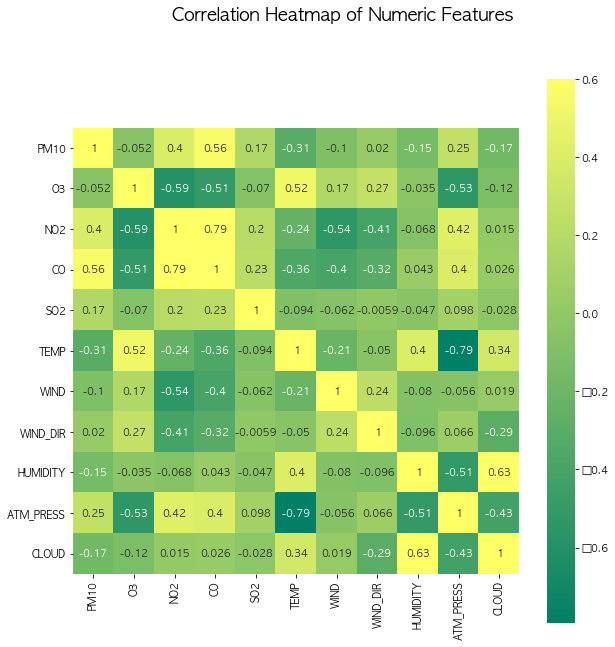

In [729]:
# MeasDate 제외한 모든 컬럼과 PM10(Target value)와의 상관관계 heatmap화
fig = plt.figure()
flg,ax = plt.subplots(figsize=[10, 10])
df_corr = df_raw.drop('MeasDate', axis=1).dropna().corr()

sns.heatmap(df_corr, annot=True, square=True, vmax=0.6, cmap=plt.cm.summer)
plt.suptitle('Correlation Heatmap of Numeric Features', fontsize=18)

In [730]:
n = len(df_corr.columns)
df_corr.nlargest(n, columns='PM10')['PM10']

PM10         1.000000
CO           0.560574
NO2          0.395883
ATM_PRESS    0.252929
SO2          0.172526
WIND_DIR     0.019830
O3          -0.051828
WIND        -0.100357
HUMIDITY    -0.149537
CLOUD       -0.172133
TEMP        -0.309786
Name: PM10, dtype: float64

PM10(미세먼지발생량)과 **높은 상관관계 순** 정렬 : <br>
**CO(이산화질소농도) > NO2(이산화질소농도) > ATM_PRESS(현지기압hPA) > SO2(아황산가스농도)**

# 4. 회귀분석 (선형)

In [731]:
# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형모델 formula
import statsmodels.formula.api as sml
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 선형회귀 모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진 제거법)
from sklearn.feature_selection import RFE
# scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse

### 1) 변수 간의 경향성 평가(그래프 분석)

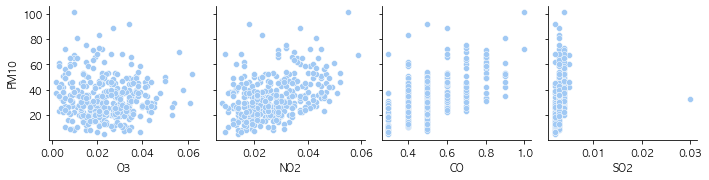

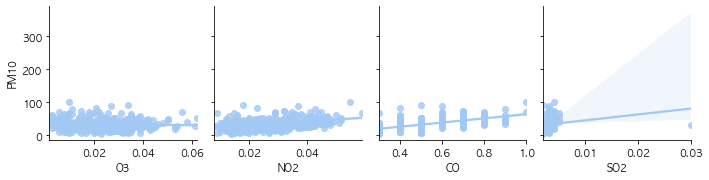

In [732]:
# 산점도 행렬(대기오염)
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "NO2", "CO", "SO2"], diag_kind = None)

# 회귀 적합선 추가 : kind="reg"
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "NO2", "CO", "SO2"], diag_kind = None, kind="reg")

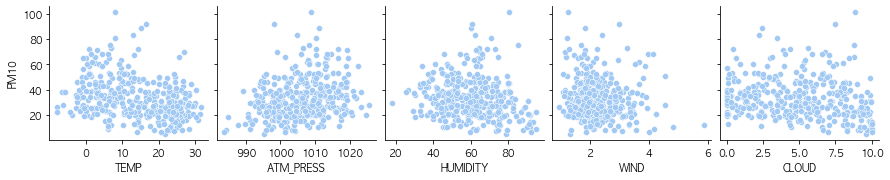

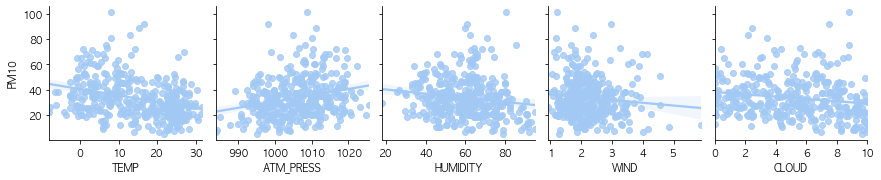

In [736]:
# 산점도 행렬(기상정보)
sns.pairplot(df_raw, y_vars="PM10", x_vars=["TEMP", "ATM_PRESS", "HUMIDITY", "WIND", "CLOUD"], diag_kind = None)

# 회귀 적합선 추가 : kind="reg"
sns.pairplot(df_raw, y_vars="PM10", x_vars=["TEMP", "ATM_PRESS", "HUMIDITY", "WIND", "CLOUD"], diag_kind = None, kind="reg")

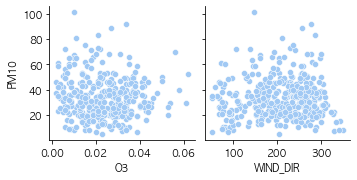

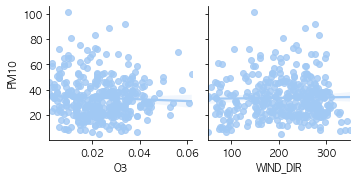

In [737]:
# 산점도 행렬(고려대상)
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "WIND_DIR"], diag_kind = None)

# 회귀 적합선 추가 : kind="reg"
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "WIND_DIR"], diag_kind = None, kind="reg")

- 목표변수(PM10)와 다수 설명변수간의 선형관계 확인
- 산점도에서 이상치 확인
- 따라서, 이상치 처리 검토 및 적절한 설명변수 선택이 필요함

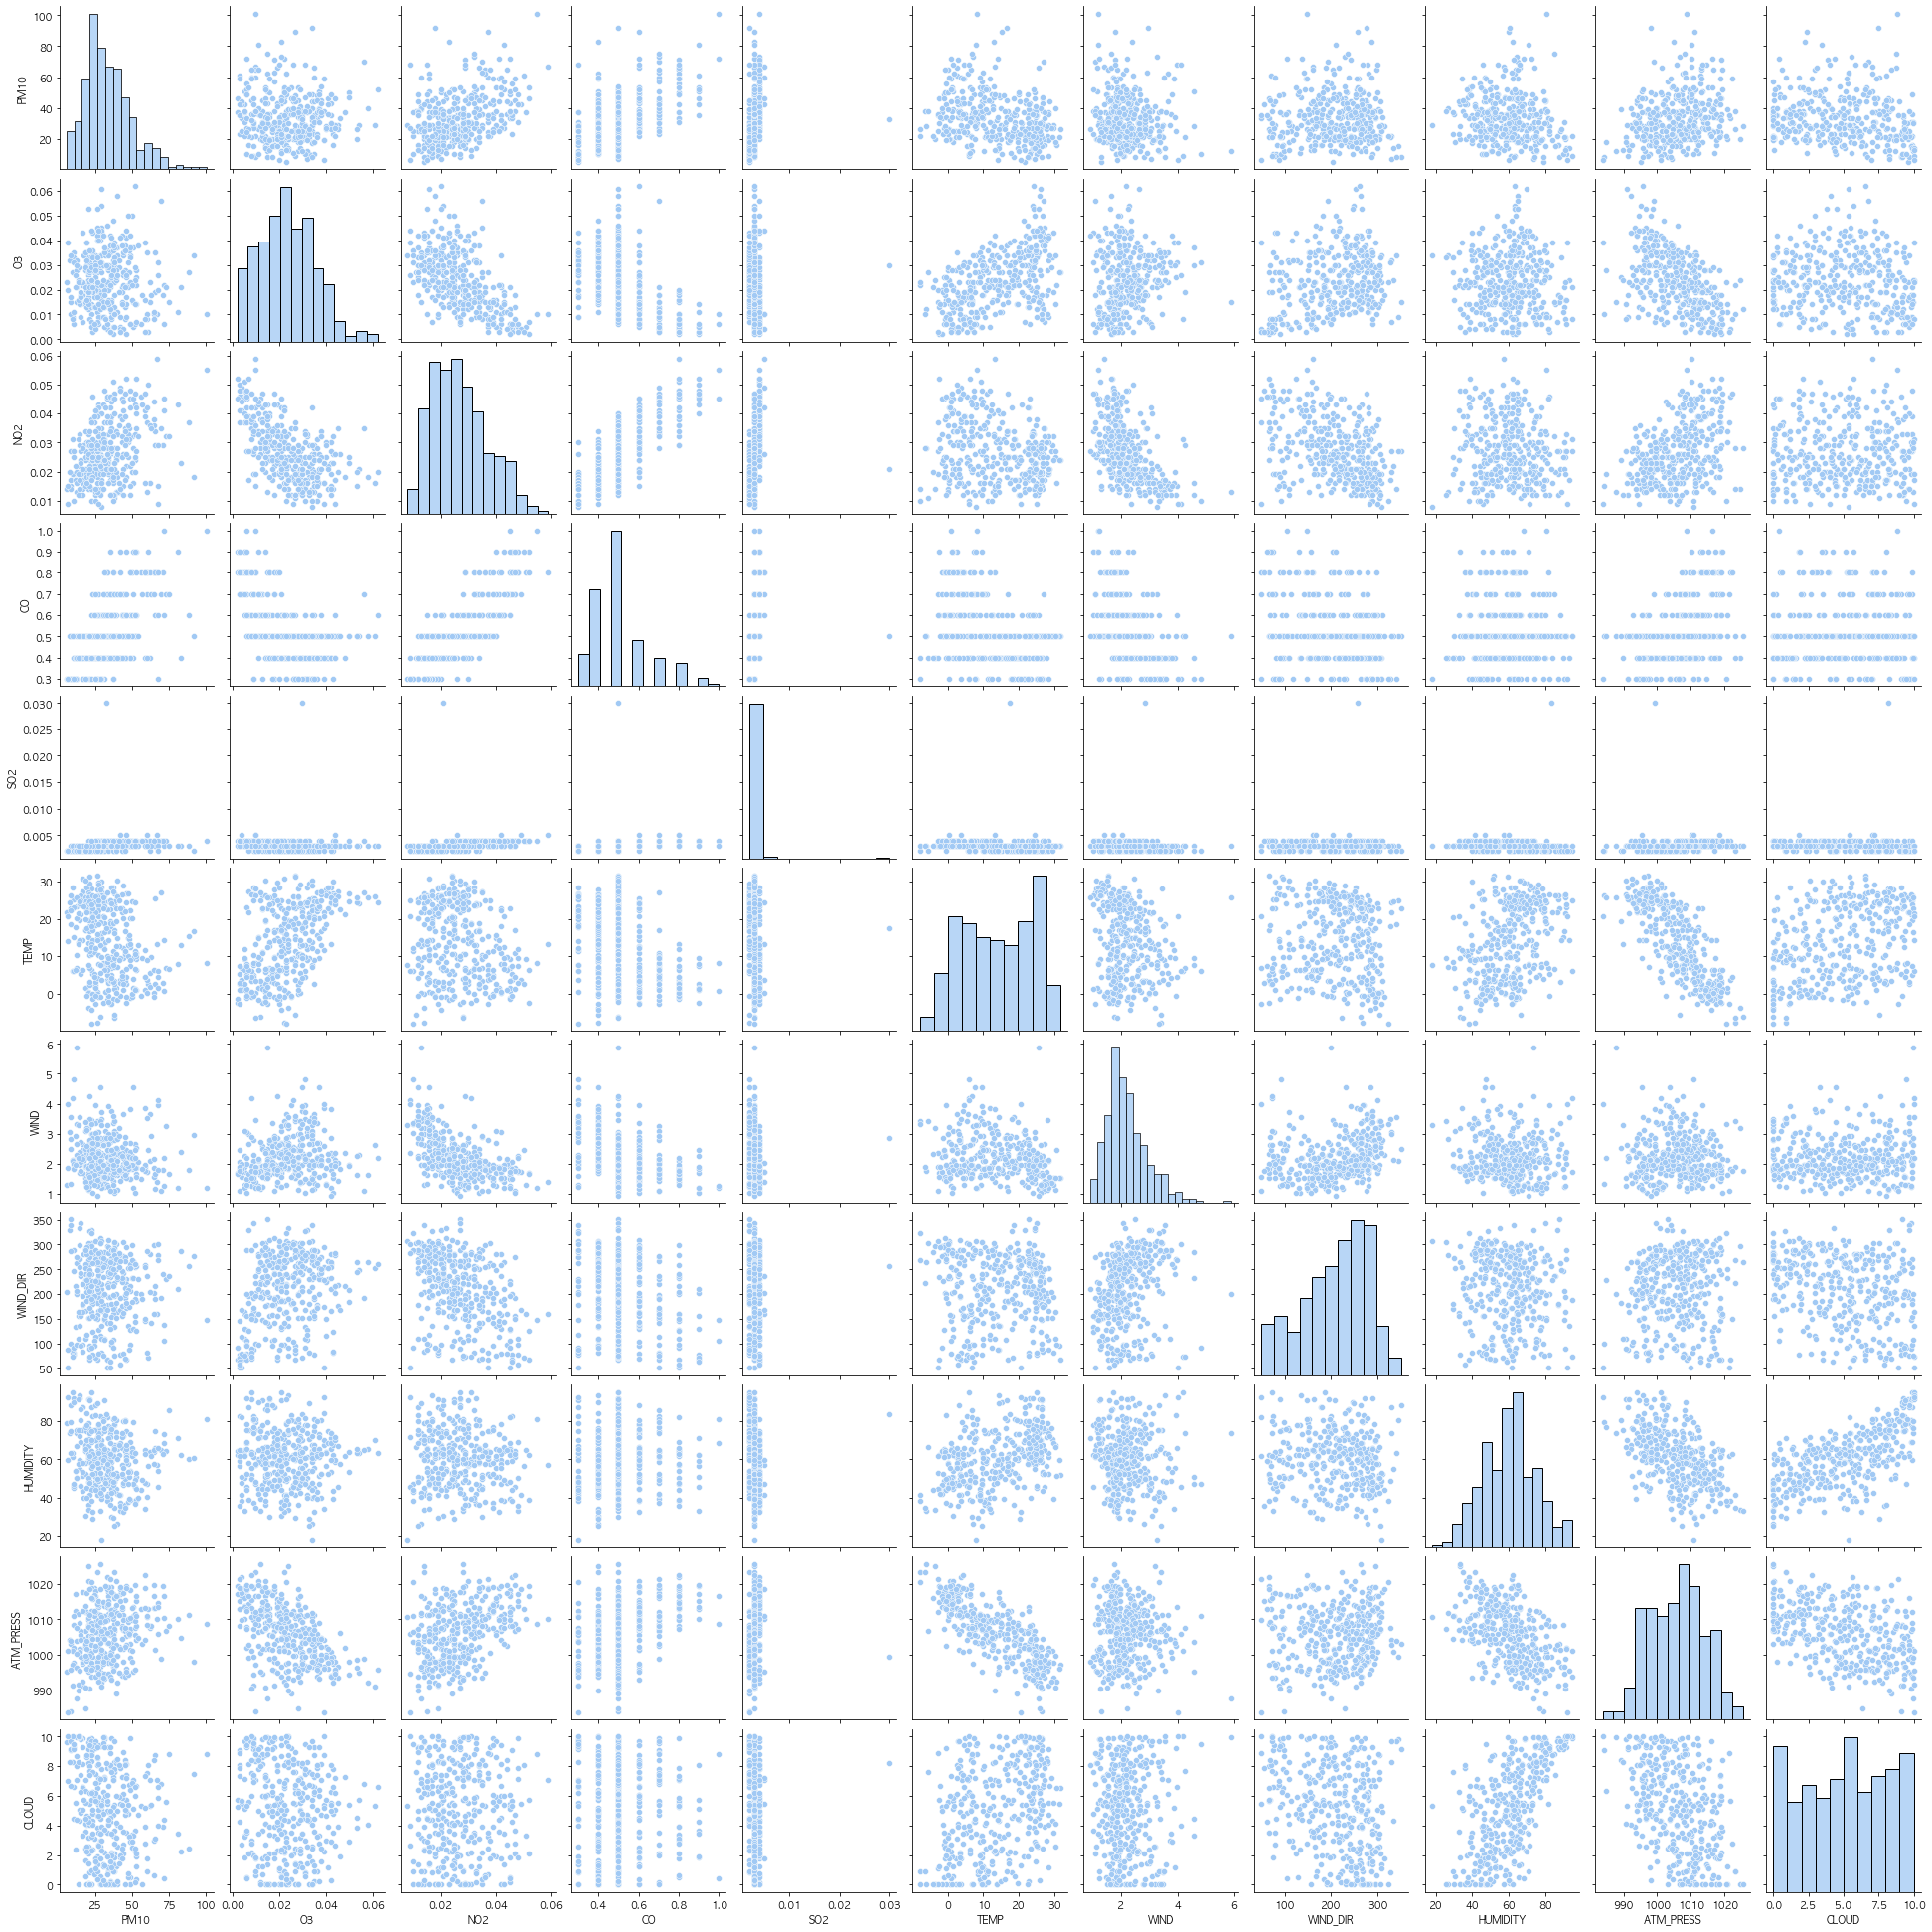

In [738]:
# 산점도 행렬 : 전체 숫자형 변수
sns.pairplot(df_raw)

- 미세먼지발생량(PM10)와 선형관계가 있는 설명변수 확인
- 설명변수 간의 선형관계 확인됨.(TEMP, 03, ATM_PRESS)
- 따라서, 설명변수 간의 다중공선성 처리 필요

In [739]:
# 상관관계 분석
df_raw.corr().round(3)

,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
PM10,1.000,-0.052,0.396,0.561,0.173,-0.310,-0.100,0.020,-0.150,0.253,-0.172
O3,-0.052,1.000,-0.592,-0.513,-0.070,0.516,0.166,0.269,-0.035,-0.535,-0.118
NO2,0.396,-0.592,1.000,0.791,0.203,-0.238,-0.537,-0.409,-0.068,0.421,0.015
CO,0.561,-0.513,0.791,1.000,0.227,-0.362,-0.403,-0.319,0.043,0.401,0.026
SO2,0.173,-0.070,0.203,0.227,1.000,-0.094,-0.062,-0.006,-0.047,0.098,-0.028
TEMP,-0.310,0.516,-0.238,-0.362,-0.094,1.000,-0.215,-0.050,0.404,-0.792,0.342
WIND,-0.100,0.166,-0.537,-0.403,-0.062,-0.215,1.000,0.236,-0.080,-0.056,0.019
WIND_DIR,0.020,0.269,-0.409,-0.319,-0.006,-0.050,0.236,1.000,-0.096,0.066,-0.294
HUMIDITY,-0.150,-0.035,-0.068,0.043,-0.047,0.404,-0.080,-0.096,1.000,-0.512,0.629
ATM_PRESS,0.253,-0.535,0.421,0.401,0.098,-0.792,-0.056,0.066,-0.512,1.000,-0.431


- 미세먼지발생량(PM10)와 CO(일산화질소농도), NO2(이산화질소농도), ATM_PRESS(현지기압) 간의 높은 선형관계 확인
- 설명변수 상관관계 : 다수 설명변수 간의 선형관계 확인
- 따라서, 다중공선성 확인 및 처리가 필요함

### 2) 회귀 모델 생성

**[ 설명변수 전체 ]**

In [740]:
# df_raw의 MeasDate 컬럼 제거
df_raw.drop(['MeasDate'], axis=1, inplace=True)

In [741]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PM10       366 non-null    float64
 1   O3         366 non-null    float64
 2   NO2        366 non-null    float64
 3   CO         366 non-null    float64
 4   SO2        366 non-null    float64
 5   TEMP       366 non-null    float64
 6   WIND       366 non-null    float64
 7   WIND_DIR   366 non-null    int64  
 8   HUMIDITY   366 non-null    float64
 9   ATM_PRESS  366 non-null    float64
 10  CLOUD      366 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 31.6 KB


In [742]:
# 선형 회귀 분석 : formula
reg_model = sml.ols(formula = "PM10 ~ O3 + NO2 + CO + SO2 + TEMP + WIND + WIND_DIR + HUMIDITY + ATM_PRESS + CLOUD", data=df_raw)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     35.05
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           3.08e-47
Time:                        16:38:05   Log-Likelihood:                -1406.0
No. Observations:                 366   AIC:                             2834.
Df Residuals:                     355   BIC:                             2877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    368.5692    158.389      2.327      0.0

- 분석 자료 수 : 366
- 잔차 자유도 : 355
- 모델 자유도 : 10

- 분산 분석 결과 : p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의


- 설명력(0.497) : 모델을 통하여 설명변수를 49.7%를 설명할 수 있음
- 회귀계수 검정
    - 절편의 유의성 검토하지 않음. 회귀식에는 절편의 유의성 상관없이 절편 포함함
    - SO2, HUMIDITY, CLOUD을 제외한 설명변수들의 p값이 유의수준 0.05보다 작으므로 유의
    - 회귀식에는 유의하지 않은 설명변수도 포함해야 함

**[ 설명변수 간의 다중공선성 확인 ]**

In [743]:
# 설명변수 간의 다중공선성 확인 : 설명변수 데이터 생성 및 상수항 추가
df_raw_x = df_raw.drop("PM10", axis=1)

# statsmodels의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x)

# DF로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

,variable,VIF
4,SO2,1.077
7,WIND_DIR,1.451
6,WIND,1.885
10,CLOUD,2.072
8,HUMIDITY,2.304
1,O3,2.676
3,CO,3.456
5,TEMP,4.246
9,ATM_PRESS,4.423
2,NO2,4.676


- 특정 설명변수에서 다중공선성이 발생한다고 보기 어려움
- 변수 제거를 따로 하지 않았으므로, 곧바로 후진제거법을 이용한 변수 선택을 진행한다.

### 3) 후진제거법을 이용한 변수 선택

**[ 후진제거법을 이용한 변수 선택]**

In [748]:
# 목표 변수 분리
df_raw_y = df_raw["PM10"]

# sklearn의 선형회귀 모델
model = LinearRegression()

# 전체변수 중 5개의 변수가 남을 때까지 변수 선택
rfe = RFE(estimator = model, n_features_to_select=5).fit(df_raw_x, df_raw_y)

# 선택된 변수
selected_cols = df_raw_x.columns[rfe.support_]

# 제거된 변수
removed_cols = df_raw_x.columns[~rfe.support_]

print("selected variables : {}".format(selected_cols))
print("removed variables: {}".format(removed_cols))

selected variables : Index(['O3', 'NO2', 'CO', 'SO2', 'WIND'], dtype='object')
removed variables: Index(['TEMP', 'WIND_DIR', 'HUMIDITY', 'ATM_PRESS', 'CLOUD'], dtype='object')


- 'O3(오존농도)', 'NO2(이산화질소농도)', 'CO(일산화질소농도)', 'SO2(아황산가스농도)', 'WIND(풍속)' 변수 선택

**[ 후진제거법을 이용한 변수 선택 및 모델 생성]**

In [749]:
# 회귀 모델 생성
rfe_reg_model = sml.ols(formula="PM10 ~ O3 + NO2 + CO + SO2 + WIND", data=df_raw)

# 적합
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     52.69
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           6.03e-41
Time:                        16:40:15   Log-Likelihood:                -1431.2
No. Observations:                 366   AIC:                             2874.
Df Residuals:                     360   BIC:                             2898.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.5408      5.595     -6.710      0.0

- 분석 자료 수 : 366
- 잔차 자유도 : 360
- 모델 자유도 : 5


- 분산 분석 결과 : p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의


- 설명력(0.423) : 모델을 통하여 설명변수를 42.3%를 설명할 수 있음
- 회귀계수 검정
    - 절편의 유의성 검토하지 않음. 회귀식에는 절편의 유의성 상관없이 절편 포함함
    - 모든 설명변수의 회귀계수 유의

- 최종 모델 회귀식<br>
ŷ = -37.5408 + 506.3154 O3 + 288.4730 NO2 + 77.9714 CO + 184.1722 SO + 4.7566 WIND

### 4) 결론 도출

**[ 변수 중요도 확인 : 비표준화 회귀계수 기준]**

<AxesSubplot:>

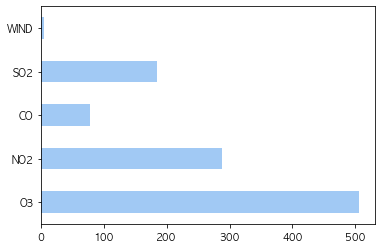

In [750]:
# 설명변수 중요도(표준화 적용 이전) -> 표준화 회귀계수 산출해야함
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y="Coef", legend=False)

- 중요도는 회귀계수의 절대값 크기
- 오존농도(O3)가 커질수록 미세먼지농도(PM10)가 높음

**[ 표준화 회귀계수를 이용한 변수 중요도 확인 ]**

In [751]:
from sklearn.preprocessing import StandardScaler

# 설명변수 표준화 적용 -> 표준화 회귀계수 산출 목적
scaler = StandardScaler()

# Scale 변환대상 변수 : 일반적으로 설명변수
cols = df_raw_x.columns

# Scale 변환
np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

# 목표변수 추가
df_scaled['PM10'] = df_raw['PM10']
reg_model_scaled = sml.ols(formula = "PM10 ~ O3 + NO2 + CO + SO2 + WIND",
                          data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     52.69
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           6.03e-41
Time:                        16:40:46   Log-Likelihood:                -1431.2
No. Observations:                 366   AIC:                             2874.
Df Residuals:                     360   BIC:                             2898.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.4194      0.637     52.498      0.0

<AxesSubplot:>

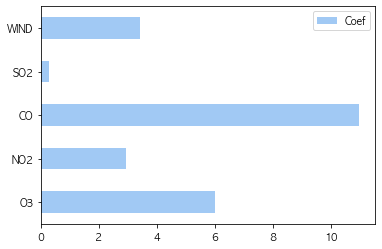

In [752]:
# 설명변수 중요도(표준화 적용 이전) -> 표준화 회귀계수 산출해야 함
df_reg_scaled_coef = pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, 
                           index=selected_cols)
df_reg_scaled_coef.plot.barh(y='Coef', legend=True)

- 표준화된 설명변수에서는 CO(일산화탄소 농도)가 높아질수록 미세먼지농도(PM10)가 높음 

#  5. 회귀분석(규제모델)

### 1) 목표변수, 설명변수 데이터 지정

In [753]:
# ridge, lasso, elasticnet 
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [754]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["PM10"]
df_raw_x = df_raw.drop("PM10", axis=1, inplace=False)

### 2) ElasticNet
: ElasticNet을 이용해서 회귀분석을 진행한다.

**[ 규제화 회귀분석 파라미터 선정 ]**

In [755]:
# 설명력 결과 저장
train_score = []

# a : 규제화 강도
para_alpha = [n_alpha * 0.1 for n_alpha in range(1, 11)]

for v_alpha in para_alpha:
    elastic = ElasticNet(random_state=1234, alpha=v_alpha)
    elastic.fit(df_raw_x, df_raw_y)
    train_score.append(elastic.score(df_raw_x, df_raw_y))
    
# 결과 저장
df_score_alpha = pd.DataFrame()
df_score_alpha["Alpha"] = para_alpha
df_score_alpha["TrainScore"] = train_score
df_score_alpha

,Alpha,TrainScore
0,0.1,0.221945
1,0.2,0.180962
2,0.3,0.163203
3,0.4,0.152584
4,0.5,0.145141
5,0.6,0.139433
6,0.7,0.134807
7,0.8,0.130920
8,0.9,0.127569
9,1.0,0.124627


- 규제화 강도가 0.1일 때 설명력이 가장 높게 나타남

**[ 최종 규제화 회귀 모델 생성 ]**

In [756]:
# 최종 모델
elastic_final = ElasticNet(alpha=0.1, random_state=1234)
result = elastic_final.fit(df_raw_x, df_raw_y)

df_elastic = pd.DataFrame()
df_elastic["variable"] = df_raw_x.columns
df_elastic["Coef"] = pd.DataFrame(result.coef_)
df_elastic

,variable,Coef
0,O3,0.000000
1,NO2,0.000000
2,CO,13.847234
3,SO2,0.000000
4,TEMP,-0.605206
5,WIND,-3.067340
6,WIND_DIR,0.013677
7,HUMIDITY,-0.054659
8,ATM_PRESS,-0.304236
9,CLOUD,-0.325246


In [757]:
# 절편값 확인
print(result.intercept_)

349.60440821304474


<AxesSubplot:>

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


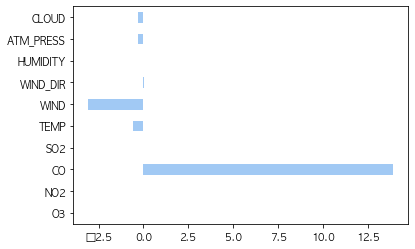

In [758]:
# 변수 중요도 확인
df_elastic_coef = pd.DataFrame({"Coef": result.coef_}, index=df_raw_x.columns)
df_elastic_coef.plot.barh(y="Coef", legend=False)

- 중요 설명변수 : CO(일산화질소농도), WIND(풍속) 의 영향이 크다고 해석할 수 있다!
- TEMP(기온), 전운량(CLOUD), 기압(ATM_PRESS), 방위(WIND_DIR)의 영향도 확인할 수 있다. 

# 6. 의사결정 트리

In [759]:
# export_grahpvis : 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz : 나무구조시각화
import graphviz

# 데이터분할 : Train, Test
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [760]:
import os

### 1) 데이터 구성하기

In [761]:
# 목표 변수, 설명 변수 데이터 지정
df_raw_y = df_raw["PM10"]
df_raw_x = df_raw.drop("PM10", axis=1, inplace=False)

In [762]:
# 데이터 분할

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)

print("train data x size : {}".format(df_train_x.shape))
print("train data y size : {}".format(df_train_y.shape))
print("test data x size : {}".format(df_test_x.shape))
print("test data y size : {}".format(df_test_y.shape))

train data x size : (256, 10)
train data y size : (256,)
test data x size : (110, 10)
test data y size : (110,)


- train : test 는 7 : 3
- train 데이터 256건, test 데이터 110건

### 2) 모델 생성

**[ 기본 옵션으로 모델 생성 ]**

In [763]:
# 기본 옵션으로 모델 생성
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 설명력
print("score on traing set : {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 설명력
print("score on test set : {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

score on traing set : 1.000
score on test set : 0.176


- 모델 설명력은 train 100%, test 17.6%로 모델은 train 데이터에 과대적합

### 3) 모델 parameter 조정

#### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [764]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# min_samples_leaf : 잎사귀 최소 자료수
para_leaf = [n_leaf*1 for n_leaf in range(1, 10)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234, 
                                 min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))


# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

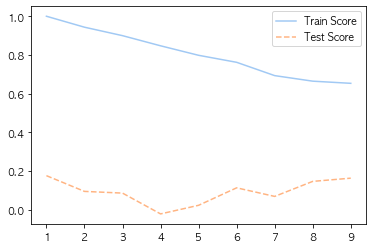

In [765]:
# 모델 설명력 확인
df_score_leaf.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소
- train/test 데이터의 성능 변화를 고려하여 9 선택

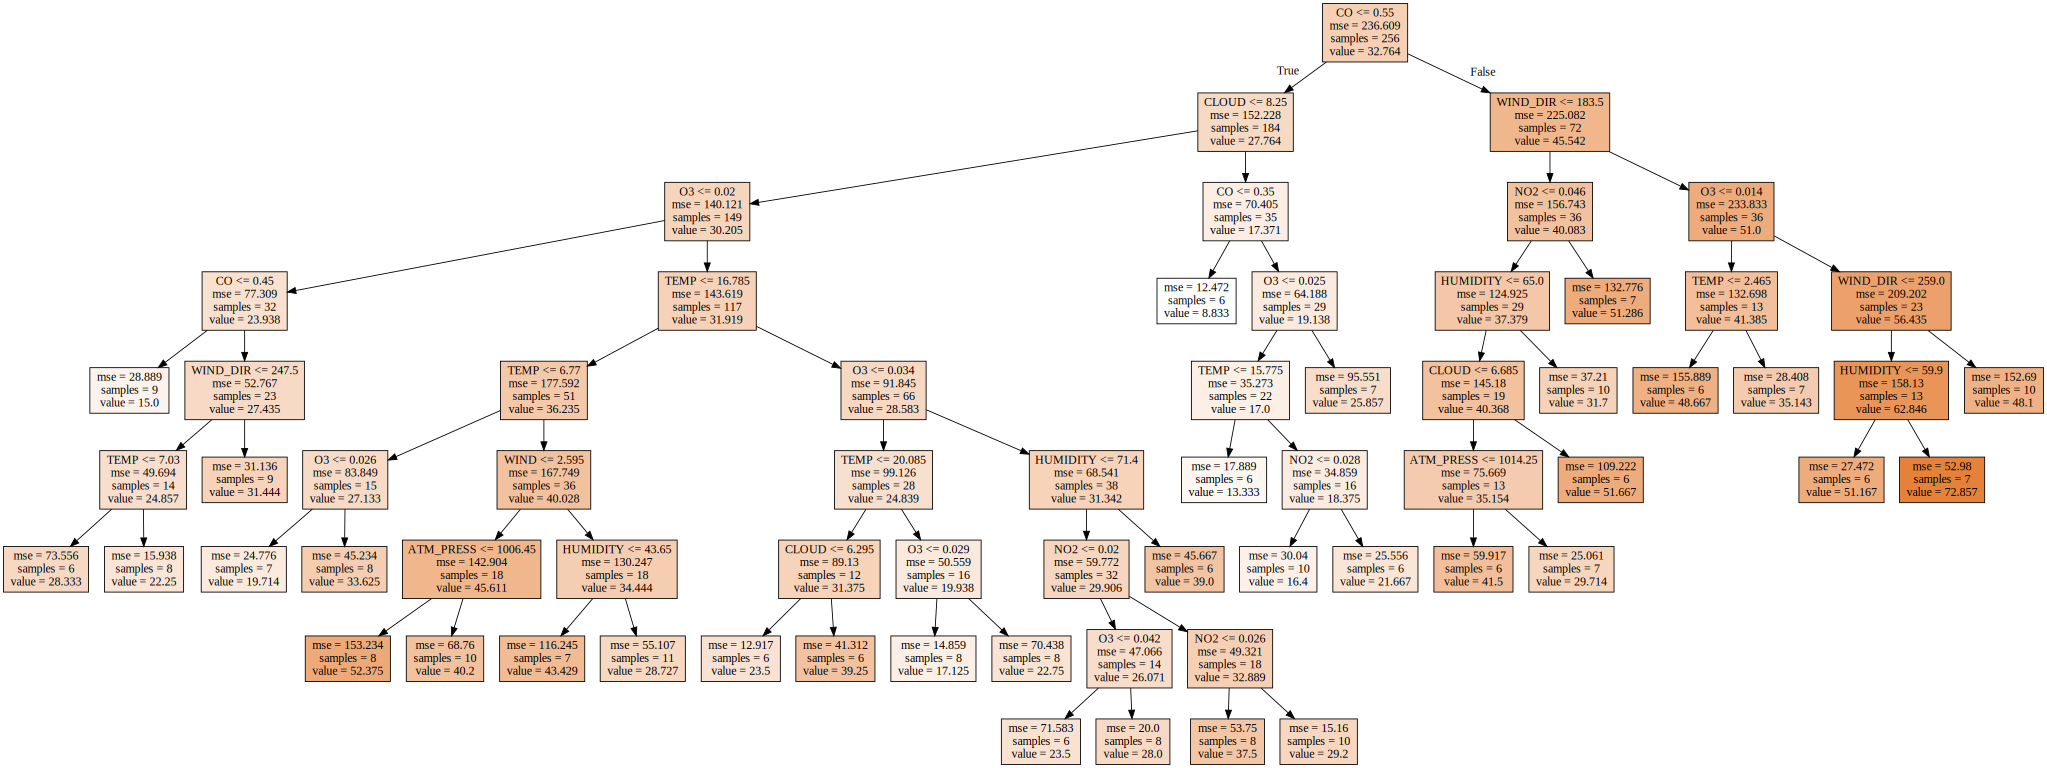

In [766]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 노드의 최소 자료수 = 6 모델
tree_graph = DecisionTreeRegressor(random_state=1234, 
                                   min_samples_leaf=6)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

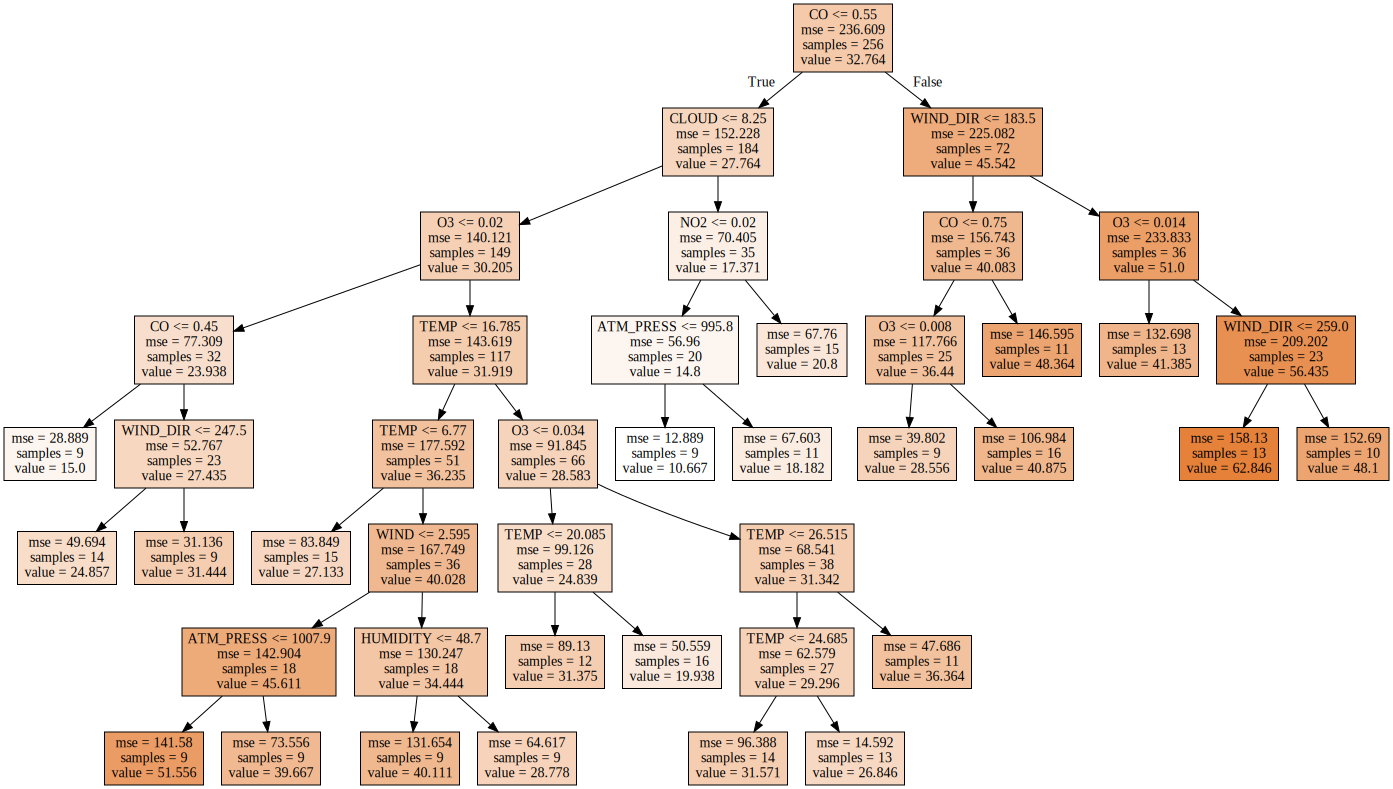

In [249]:
# 노드의 최소 자료수 = 9 모델
tree_graph = DecisionTreeRegressor(random_state=1234, 
                                   min_samples_leaf=9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

- min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능 : 자료 수 9이 균형적으로 분리

#### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [767]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# min_samples_split : 분리노드 최소 자료수
para_split = [n_split*2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, 
                                 min_samples_leaf=9,
                                 min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))


# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

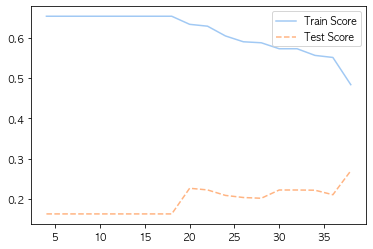

In [768]:
# 모델 설명력 확인
df_score_split.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.legend()

- 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소
- train/test 데이터의 성능 변화를 고려하여 20 선택

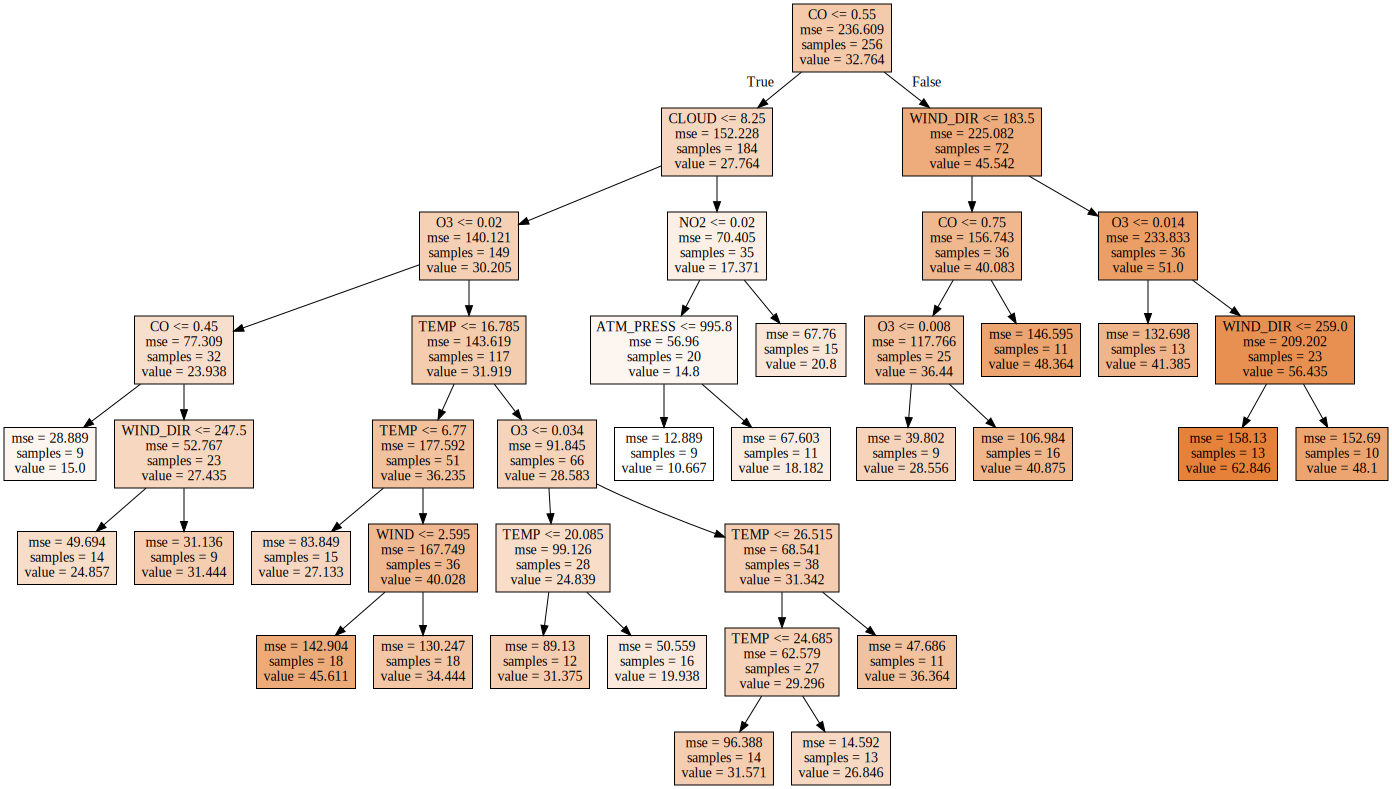

In [769]:
# 분리 노드의 최소 자료수 = 20인 모델
tree_graph = DecisionTreeRegressor(random_state=1234, 
                                   min_samples_leaf=9, 
                                   min_samples_split=20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_split.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

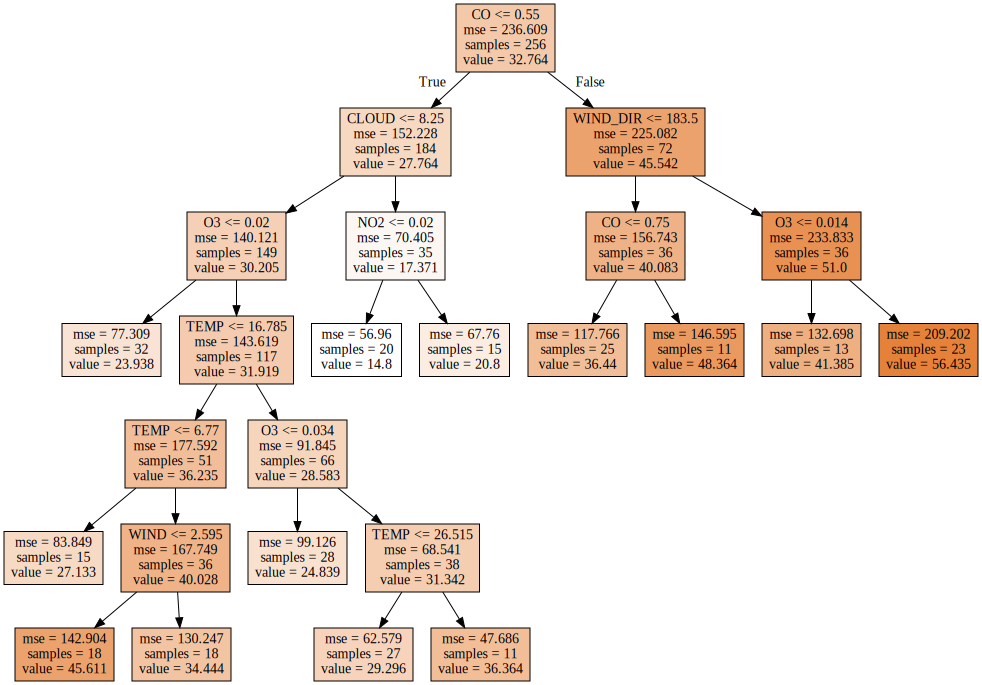

In [770]:
# 분리 노드의 최소 자료수 = 35인 모델
tree_graph = DecisionTreeRegressor(random_state=1234, 
                                   min_samples_leaf=9, 
                                   min_samples_split=35)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_split.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### max_depth : 최대 깊이 변경에 따른 모델 성능

In [771]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# max_depth : 최대 길이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, 
                                 min_samples_leaf=9, 
                                 min_samples_split=20, 
                                 max_depth=v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))


# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

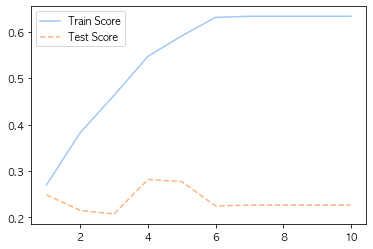

In [772]:
# 모델 설명력 확인
df_score_depth.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가

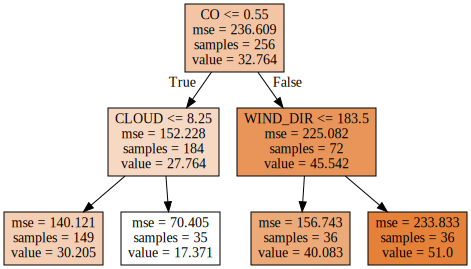

In [773]:
# 최대 깊이 = 2인 모델
tree_graph = DecisionTreeRegressor(random_state=1234,
                                   min_samples_leaf=9, 
                                   min_samples_split=20, 
                                   max_depth=2)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_depth.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_depth.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

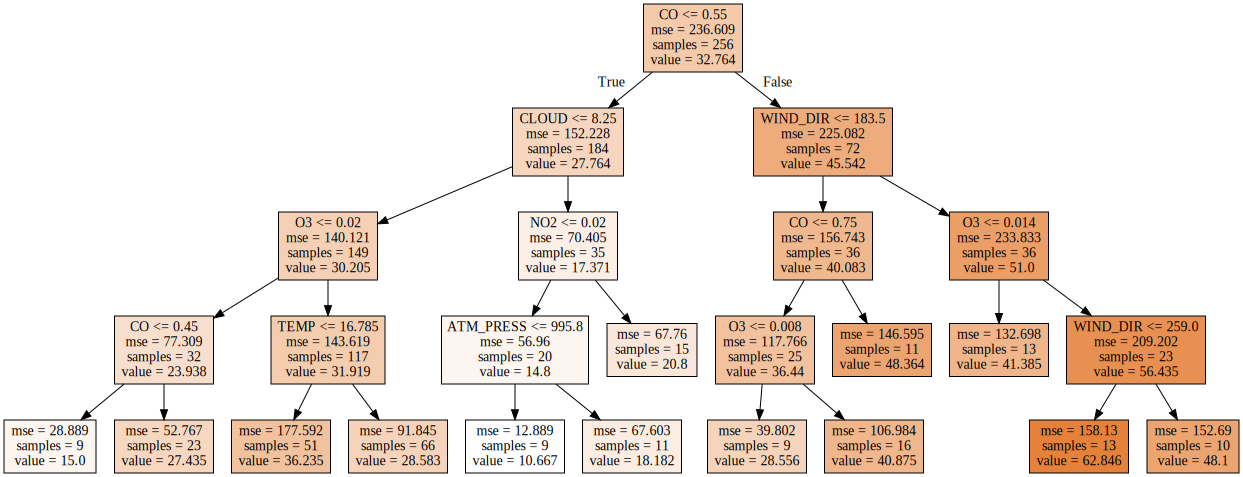

In [775]:
# 최대 깊이 = 4인 모델
tree_graph = DecisionTreeRegressor(random_state=1234, 
                                   min_samples_leaf=9, 
                                   min_samples_split=20, 
                                   max_depth=4)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_depth.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_depth.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

- train/test 데이터의 성능 변화를 고려하여 4 선택

## 4) 최종 모델 선정

**[ 최종 모델 ]**

In [776]:
tree_final = DecisionTreeRegressor(min_samples_leaf=9, 
                                   min_samples_split=20, 
                                   max_depth=4, 
                                   random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=9, min_samples_split=20,
                      random_state=1234)

**[ 최종 모델 시각화 ]**

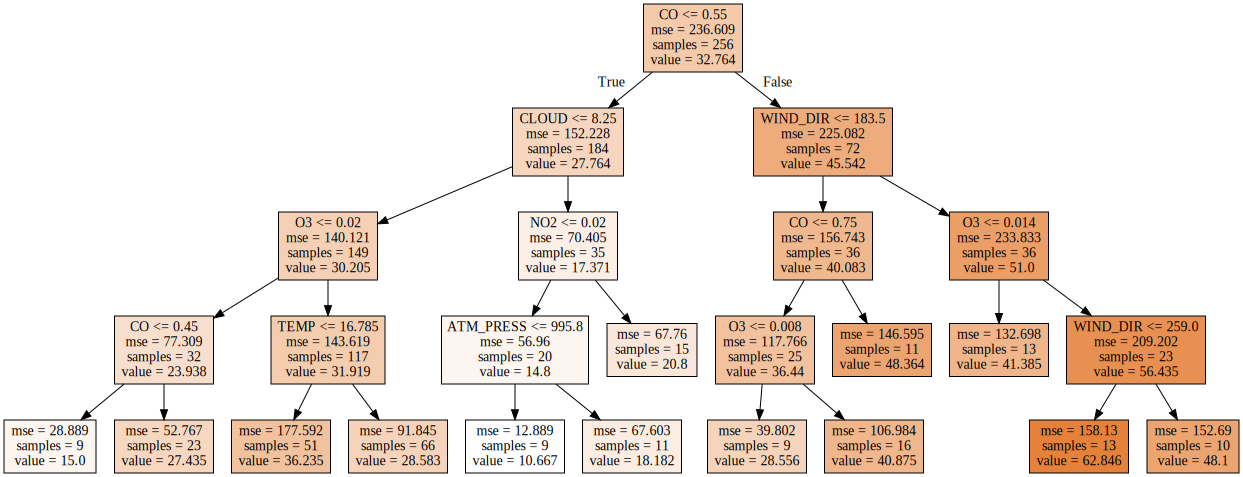

In [777]:
export_graphviz(tree_final, out_file="tree_final.dot",
               feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [780]:
# train 데이터 설명력
print("score on traing set : {:.3f}".format(tree_final.score(df_train_x, df_train_y)))

# test 데이터 설명력
print("score on test set : {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

score on traing set : 0.547
score on test set : 0.282


## 5) 결론 도출

**[ feature_importances_ : 설명변수의 중요도 ]**

In [778]:
# tree.feature_importances_로 섬령변수 중요도 확인 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.557
9,CLOUD,0.141
0,O3,0.132
6,WIND_DIR,0.102
4,TEMP,0.051
1,NO2,0.009
8,ATM_PRESS,0.008
3,SO2,0.000
5,WIND,0.000
7,HUMIDITY,0.000


Text(0, 0.5, '변수')

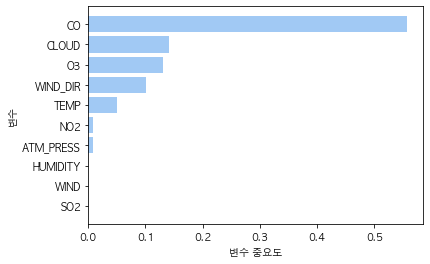

In [779]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- CO(일산화탄소농도)가 눈에 띄게 영향이 큼
- 이후로는 CLOUD(전운량), O3(오존), WIND_DIR(풍향), TEMP(기온) 순으로 영향이 큼
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

# 7. Random Forest

In [781]:
from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### 1) 데이터 구성하기

In [782]:
# 목표 변수, 설명 변수 데이터 지정
df_raw_y = df_raw["PM10"]
df_raw_x = df_raw.drop("PM10", axis=1, inplace=False)

In [783]:
# 데이터 분할

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)

print("train data x size : {}".format(df_train_x.shape))
print("train data y size : {}".format(df_train_y.shape))
print("test data x size : {}".format(df_test_x.shape))
print("test data y size : {}".format(df_test_y.shape))

train data x size : (256, 10)
train data y size : (256,)
test data x size : (110, 10)
test data y size : (110,)


- train 데이터 256건, test 데이터 110건

### 2) 모델 생성 : parameter 조정/평가

**[ 기본 옵션으로 모델 생성 ]**

In [784]:
# 기본 옵션으로 모델 생성
rf_uncustomized = DecisionTreeRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 설명력
print("score on traing set : {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 설명력
print("score on test set : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

score on traing set : 1.000
score on test set : 0.176


- 모델 설명력은 train 100%, test 17.6%로 모델은 train 데이터에 과대적합

#### n_estimators : 트리 수 변경에 따른 모델 성능

In [785]:
# train, test 설명력 결과 저장
train_score = []
test_score = []

# min_samples_leaf : 입사귀 최소 자료수
para_n_tree = [n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))


# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

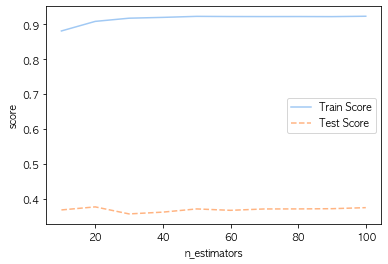

In [786]:
# 모델 설명력 확인
df_score_n.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

- 생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가
- 트리 수가 30개를 초과해도 설명력은 거의 향상되지 않음
- 최대 트리 수에 따른 영향을 배제하고 다른 파라미터의 영향을 확인하고자 100 선택

#### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [788]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# min_samples_leaf : 잎사귀 최소 자료수
para_leaf = [n_leaf*1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, 
                               n_estimators=100,
                               min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))


# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

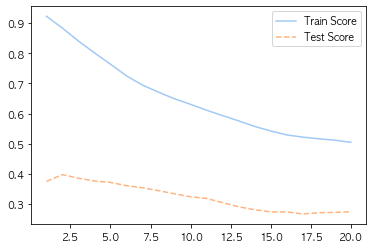

In [789]:
# 모델 설명력 확인
df_score_leaf.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소
- test 데이터의 정확도 변화를 고려하여 7 선택

#### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [790]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# min_samples_split : 분리노드 최소 자료수
para_split = [n_split*2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, 
                               n_estimators=100,
                               min_samples_leaf=7,
                               min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))


# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

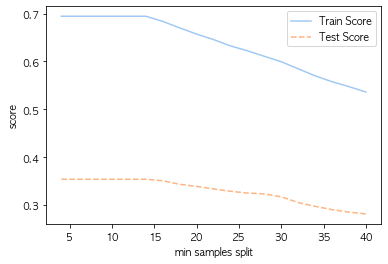

In [791]:
# 모델 설명력 확인
df_score_split.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

- 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소
- train/test 데이터의 성능 변화를 고려하여 15 선택

#### max_depth : 최대 깊이 변경에 따른 모델 성능

In [792]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# max_depth : 최대 길이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, 
                                 n_estimators=100,
                                 min_samples_leaf=7, 
                                 min_samples_split=15, 
                                 max_depth=v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))


# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

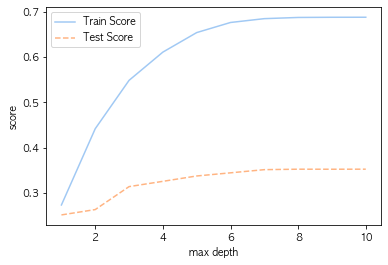

In [793]:
# 모델 설명력 확인
df_score_depth.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

- 최대 깊이 증가에 다라 모델의 설명력은 증가
- train/test 데이터의 성능 변화를 고려하여 8 선택

### 3) 결론 도출

In [1]:
rf_final = RandomForestRegressor(n_estimators=100,
                                 min_samples_leaf=7, 
                                 min_samples_split=15, 
                                 max_depth=8, 
                                 random_state=1234)
rf_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("score of training set : {:.3f}".format(rf_final.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("score of test set : {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

NameError: name 'RandomForestRegressor' is not defined

#### 최종 모델 시각화 : 생성된 트리 100개 중에서 임의의 3개 확인

In [797]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 0번 트리
export_graphviz(rf_final.estimators_[0], 
                out_file="rfr_final_0.dot",
                feature_names=v_feature_name,
                impurity=False,
                filled=False)

# tree_final_0.dot 그리기
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


# 1번 트리
export_graphviz(rf_final.estimators_[1], 
                out_file="rfr_final_1.dot",
                feature_names=v_feature_name,
                impurity=False,
                filled=False)

# tree_final_1.dot 그리기
with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))



# 10번 트리
export_graphviz(rf_final.estimators_[10], 
                out_file="rfr_final_10.dot",
                feature_names=v_feature_name,
                impurity=False,
                filled=False)


# tree_final_10.dot 그리기
with open("rfr_final_10.dot") as f:b
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

IndentationError: unexpected indent (<ipython-input-797-939135f077b0>, line 41)

- 위와 같은 트리 100개(n_estimatros=100으로 지정)를 조합하여 최종 모델 생성

#### feature_importances_ : 설명변수의 중요도

In [798]:
# tree.feature_importances_로 설명변수 중요도 확인 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.466
0,O3,0.145
9,CLOUD,0.090
4,TEMP,0.063
6,WIND_DIR,0.059
1,NO2,0.049
7,HUMIDITY,0.044
3,SO2,0.037
5,WIND,0.026
8,ATM_PRESS,0.022


Text(0, 0.5, '변수')

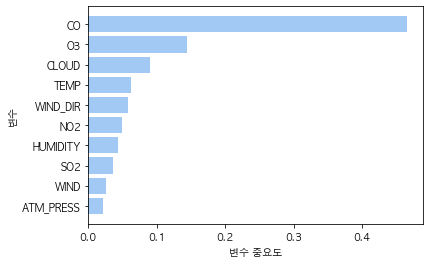

In [799]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- CO(일산화탄소 농도), O3(오존), 전운량(CLOUD) 순으로 영향이 큼
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

# 8.  Gradient Boosting

In [813]:
# export_grahpvis : 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz

# graphviz : 나무구조시각화
import graphviz

# 데이터분할 : Train, Test
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR


import os

### 1)  데이터 구성하기  

In [814]:
# 목표 변수, 설명 변수 데이터 지정
df_raw_y = df_raw["PM10"]
df_raw_x = df_raw.drop("PM10", axis=1, inplace=False)

In [815]:
# 데이터 분할

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, 
                                                                df_raw_y, 
                                                                test_size=0.3, 
                                                                random_state=1234)

print("train data x size : {}".format(df_train_x.shape))
print("train data y size : {}".format(df_train_y.shape))
print("test data x size : {}".format(df_test_x.shape))
print("test data y size : {}".format(df_test_y.shape))

train data x size : (256, 10)
train data y size : (256,)
test data x size : (110, 10)
test data y size : (110,)


- train 데이터 256건, test 데이터 110건

### 2) 모델 생성 

**[ 기본 옵션으로 모델 생성 ]**

In [816]:
# 기본 옵션으로 모델 생성
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 설명력
print("score on traing set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 설명력
print("score on test set : {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

score on traing set : 0.930
score on test set : 0.416


- 모델 설명력은 train 93%, test 41.6%로 모델은 train 데이터에 과대적합

#### n_estimators : 트리 수 변경에 따른 모델 성능

In [818]:
# train, test 설명력 결과 저장
train_score = []
test_score = []

# min_samples_leaf : 입사귀 최소 자료수
para_n_tree = [n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GBR(n_estimators=v_n_estimators, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))


# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

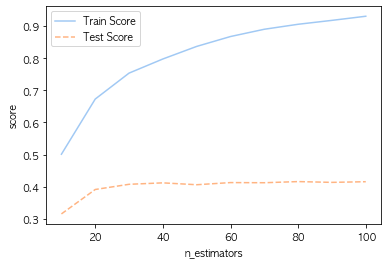

In [819]:
# 모델 설명력 확인
df_score_n.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

- 생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가
- Test 데이터의 성능 변화를 고려하여 100 선택

#### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [820]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# min_samples_leaf : 입사귀 최소 자료수
para_leaf = [n_leaf*1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GBR(random_state=1234, 
             n_estimators=100,
             min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))


# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

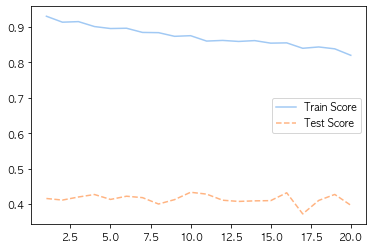

In [821]:
# 모델 설명력 확인
df_score_leaf.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소
- test 데이터의 성능 변화를 고려하여 10 선택

#### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [822]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# min_samples_split : 분리노드 최소 자료수
para_split = [n_split*2 for n_split in range(1, 21)]

for v_min_samples_split in para_split:
    gb = GBR(random_state=1234,
             n_estimators=100,
             min_samples_leaf=10,
             min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))


# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

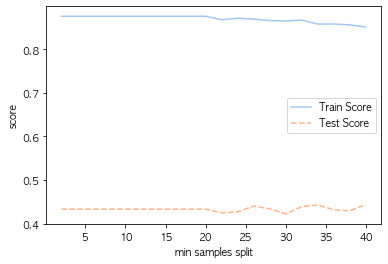

In [823]:
# 모델 설명력 확인
df_score_split.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

- 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 다소 감소
- train/test 데이터의 성능 변화를 고려하여 20 선택

#### max_depth : 최대 깊이 변경에 따른 모델 성능

In [824]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# max_depth : 최대 길이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GBR(random_state=1234, 
             n_estimators=100,
             min_samples_leaf=10, 
             min_samples_split=20, 
             max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))


# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

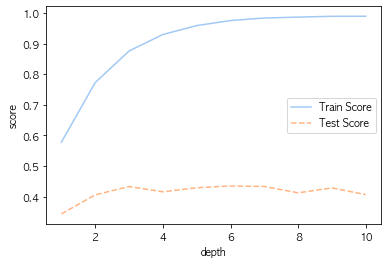

In [825]:
# 모델 설명력 확인
df_score_depth.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("depth")
plt.legend()

- 최대 깊이 증가에 다라 모델의 설명력은 증가
- train/test 데이터의 성능 변화를 고려하여 7 선택

#### learning_rate : 학습률 변경에 따른 모델 성능

In [826]:
# train, test 설명력 결과 저장
train_score = [];
test_score = []

# learning rate : 학습률 변경 0.1 ~ 0.9
para_lr = [lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GBR(random_state=1234, 
             n_estimators=100,
             min_samples_leaf=10, 
             min_samples_split=20, 
             max_depth=7, 
             learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))


# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score

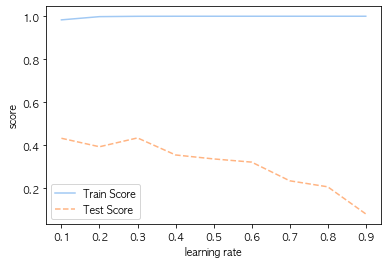

In [827]:
# 모델 설명력 확인
df_score_lr.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle="-", label="Train Score")
plt.plot(para_lr, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

- 학습률 증가에 따라 모델의 설명력은 증가
- test 데이터의 성능 급격하게 저하되어 0.1 선택
- 0.1~-0.2 사이의 세밀한 변화에 따른 성능 변화 확인 핑료

## 3) 결론 도출

In [836]:
gb_final = GBR(random_state=1234,
               n_estimators=100,
               min_samples_leaf=10, 
               min_samples_split=15, 
               max_depth=7, 
               learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("score of training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("score of test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))
      

score of training set : 0.983
score of test set : 0.433


#### feature_importances_ : 설명변수의 중요도

In [837]:
# 변수명 저장
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.364
0,O3,0.145
4,TEMP,0.102
9,CLOUD,0.096
6,WIND_DIR,0.076
7,HUMIDITY,0.053
8,ATM_PRESS,0.046
1,NO2,0.046
5,WIND,0.043
3,SO2,0.028


Text(0, 0.5, '변수')

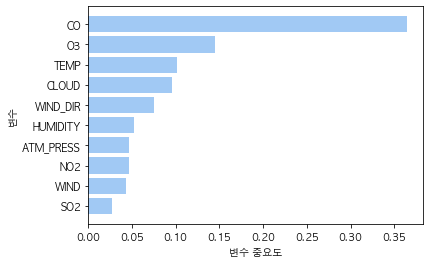

In [838]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- CO(일산화탄소 농도), O3(오존), 기온(TEMP), 전운량(CLOUD) 순으로 영향이 큼
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음